In [1]:

import jax
import os



os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.0'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
print(jax.local_devices())



import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy

from jax import random


import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

from scipy import integrate

import time

from jax.numpy import fft

from tqdm import tqdm

import math

from jax import grad

from scipy import integrate

[cuda(id=0)]


In [2]:
from jax import jit, grad, vmap, hessian, value_and_grad
import optax

In [3]:
#plt.style.use('default')
plt.style.use('plot_style-Examples_3d.txt')

# 16:9 aspect ratio
width = 4
height = width * 3 / 4

In [4]:
# Testing the sine transform
def discrete_sine_transform(y):
    n = y.shape[0]
    y_extended = jnp.concatenate([y,  -y[::-1]])
    y_fft = fft.rfft(y_extended)
    return (-y_fft.imag/(jnp.sqrt(2)*(n)))[:-1] # Removing the last spurious element 

vmap_dst = jit(vmap(discrete_sine_transform, in_axes=(0,)))
@jit
def dst_2d(A):
    # Receives a 2d array and returns the 2d discrete sine transform
    return vmap_dst(vmap_dst(A).T).T


vmap_dst_2d = jit(vmap(dst_2d, in_axes = 0))#jit(vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1))
@jit
def double_dst_2d(A):
    # Transform along the last 2 axes
    A = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(A)
    # Transpose the axes
    A = jnp.transpose(A, (2, 3, 0, 1))
    # Transform along the last 2 axes
    A = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(A)
    # Transpose the axes (going back to the original order)
    A = jnp.transpose(A, (2, 3, 0,1))
    return A



def compute_2d_error(pred, u, x, y):
    norm_u = jnp.sqrt(integrate.trapezoid(integrate.trapezoid(u**2, x), y))
    norm_diff = jnp.sqrt(integrate.trapezoid(integrate.trapezoid((pred - u)**2, x), y))
    return norm_diff, norm_diff/norm_u

def create_interior(x, y):
    # Use meshgrid to create the grid of pairs
    A, B = jnp.meshgrid(x, y, indexing='ij')

    # Combine A and B into pairs
    interior = jnp.stack((A, B), axis=-1).reshape(-1, 2)
    return interior

In [5]:
def evaluate_function_sine_2d(x, y, k,l ,c):
    values = c*jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*k*x), jnp.sqrt(2)*jnp.sin(jnp.pi*l*y))
    values = jnp.where(k==0, c*jnp.outer(jnp.ones_like(x), jnp.sqrt(2)*jnp.sin(jnp.pi*l*y)), values)
    values = jnp.where(l==0, c*jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*k*x), jnp.ones_like(y)), values)
    return values
def evaluate_basis_sine_2d(x,y,c):
    # The frequency starts at 0
    f_1 = jnp.arange(0, c.shape[0])
    f_2 = jnp.arange(0, c.shape[0])
    return jnp.sum(jit(vmap(vmap(evaluate_function_sine_2d, in_axes=(None,None,0,None, 0), out_axes= -1), in_axes= (None, None, None, 0, 1),out_axes= -1))(x, y,f_1, f_2, c), axis = (2,3))#jit(vmap(vmap(evaluate_function_sine_2d, in_axes=(None,None,None,0, 1)), in_axes= (None, None, 0, None, 0)))(x, y,f_1, f_2, c)#vmap(evaluate_function_sine_2d, in_axes=(None,None,0,0, 0))(x, y,f_1, f_2, c)


def evaluate_function_sine_2d_iterative(x,y,c):
    values = jnp.zeros_like(jnp.outer(x, y))
    for k in range(c.shape[0]):
        for l in range(c.shape[1]):
            values += c[k,l]*jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*k*x), jnp.sqrt(2)*jnp.sin(jnp.pi*l*y))
    return values

In [6]:
# Define the neural network
def init_params(layer_sizes, key):
    params = []
    keys = random.split(key, len(layer_sizes))
    for m, n, key in zip(layer_sizes[:-1], layer_sizes[1:], keys):
        weights = random.normal(key, (m, n)) * jnp.sqrt(2 / m)
        biases = jnp.zeros(n)
        params.append((weights, biases))
    return params

def predict(params, x):
    activations = x
    for weights, biases in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, weights) + biases)
    final_weights, final_biases = params[-1]
    return jnp.squeeze(jnp.dot(activations, final_weights) + final_biases)

In [7]:
def count_parameters(params):
    total_params = 0
    for weights, biases in params:
        total_params += weights.size
        total_params += biases.size
    return total_params

# Semilinear example


We will consider the problem 

\begin{aligned}
 -\nu \Delta u + c \sin(\beta 2\pi u) &= \xi \quad x \in \Omega\\
u &= 0 \quad x \in \partial \Omega
\end{aligned}

with a manufactured solution 


\begin{aligned}
u = \sum_{k=1}^\infty\sum_{l=1}^\infty \frac{u_{kl}}{(k^2 + l^2)^{\alpha + \delta}} \sin(\pi k x) \sin(\pi l y) \quad  u_{kl} \sim \mathcal{N}(0, 1)
\end{aligned}


In [8]:
lower = 0.0
upper = 1.0
domain = jnp.array([lower,upper])

In [9]:
key = random.PRNGKey(558)

n_coef = 2**7
print("Number of coefficients: ", n_coef)

c = 1.0
beta = 0.5

nu = 1e-1
#b = jit(lambda x, y: jnp.cos(5*jnp.pi*(x**2 + y**4)) + x**2 + jnp.exp(-y**2)+ 1.5)
b = lambda x,y: 0
vmap_b = jit(vmap(vmap(b, in_axes = (None, 0)), in_axes = (0, None)))


x_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)
y_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)
X, Y = jnp.meshgrid(x_finest, y_finest)
# Use meshgrid to create the grid of pairs
A, B = jnp.meshgrid(x_finest, y_finest, indexing='ij')
interior_finest = jnp.stack((A, B), axis=-1).reshape(-1, 2)



frequencies = jnp.arange(0, n_coef)

delta = .15
alpha = 1.
random_draw =  random.normal(key, shape= (n_coef,n_coef))
decay = (jnp.arange(0,n_coef)[None]**2 + jnp.arange(0,n_coef)[:,None]**2)
coef_u =random_draw*(decay)**(-alpha -delta)
coef_u= coef_u.at[:,0].set(0)
coef_u= coef_u.at[0,:].set(0)
coef_laplacian =coef_u*((nu*jnp.pi**2*decay))



Number of coefficients:  128


In [10]:
tau = jit(lambda x: c*jnp.sin(beta*2*jnp.pi*x))
tau_prime = jit(lambda x: c*jnp.cos(beta*2*jnp.pi*x)*beta*2*jnp.pi)


# tau = jit(lambda x: x**3/3)
# tau_prime = jit(lambda x: x**2)

In [11]:
u_values = evaluate_basis_sine_2d(x_finest,y_finest, coef_u)
f_values =evaluate_basis_sine_2d(x_finest,y_finest, coef_laplacian) + vmap_b(x_finest, y_finest)*u_values + tau(u_values) #c*jnp.sin(beta*2*jnp.pi*u_values)

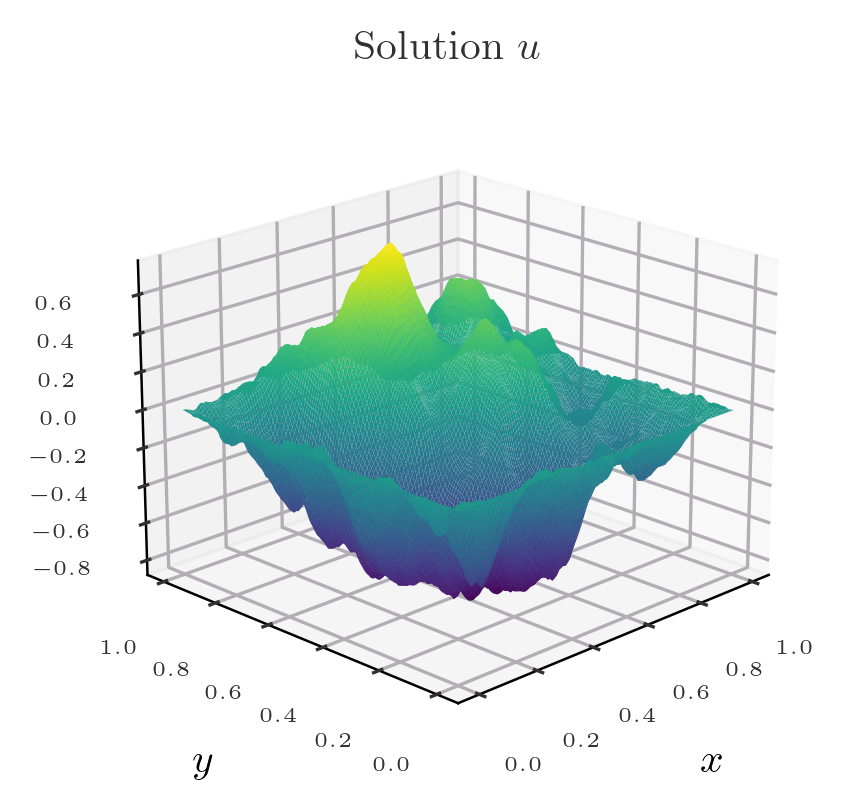

In [12]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Solution $u$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

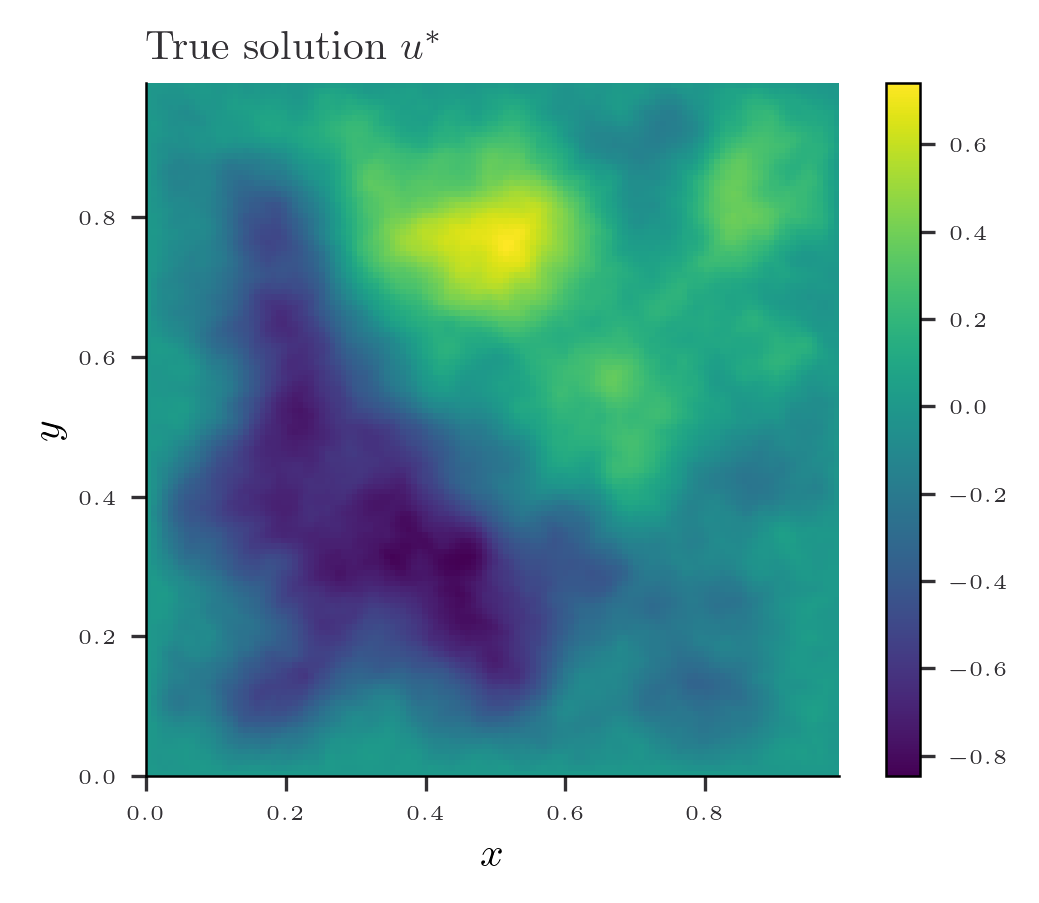

In [13]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values[::-1, :], cmap='viridis', extent=[x_finest.min(), x_finest.max(), y_finest.min(), y_finest.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

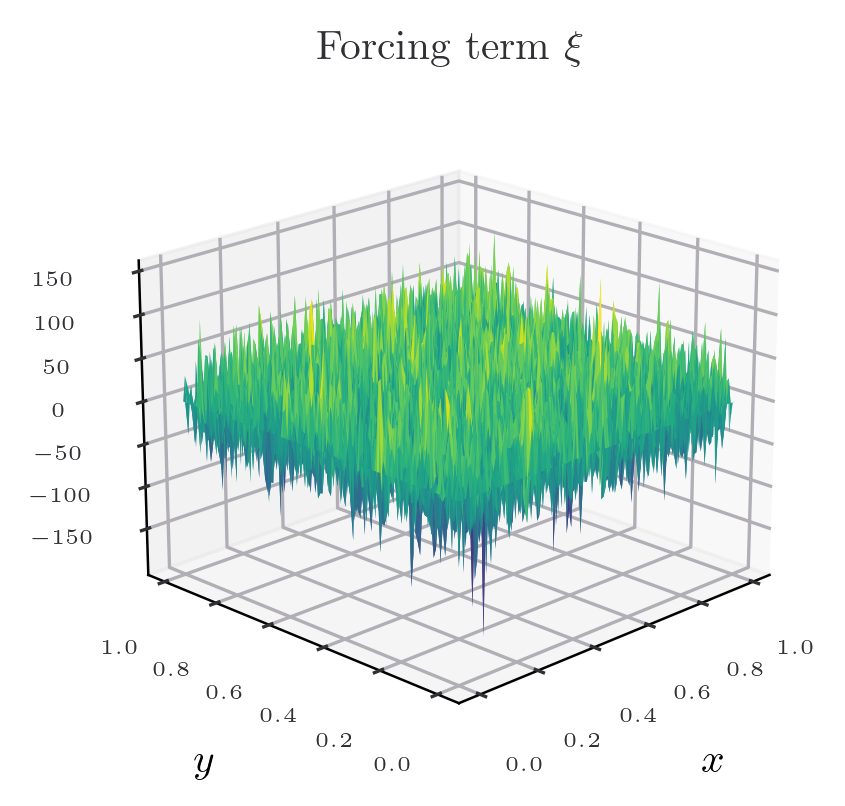

In [14]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, f_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Forcing term $\xi$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

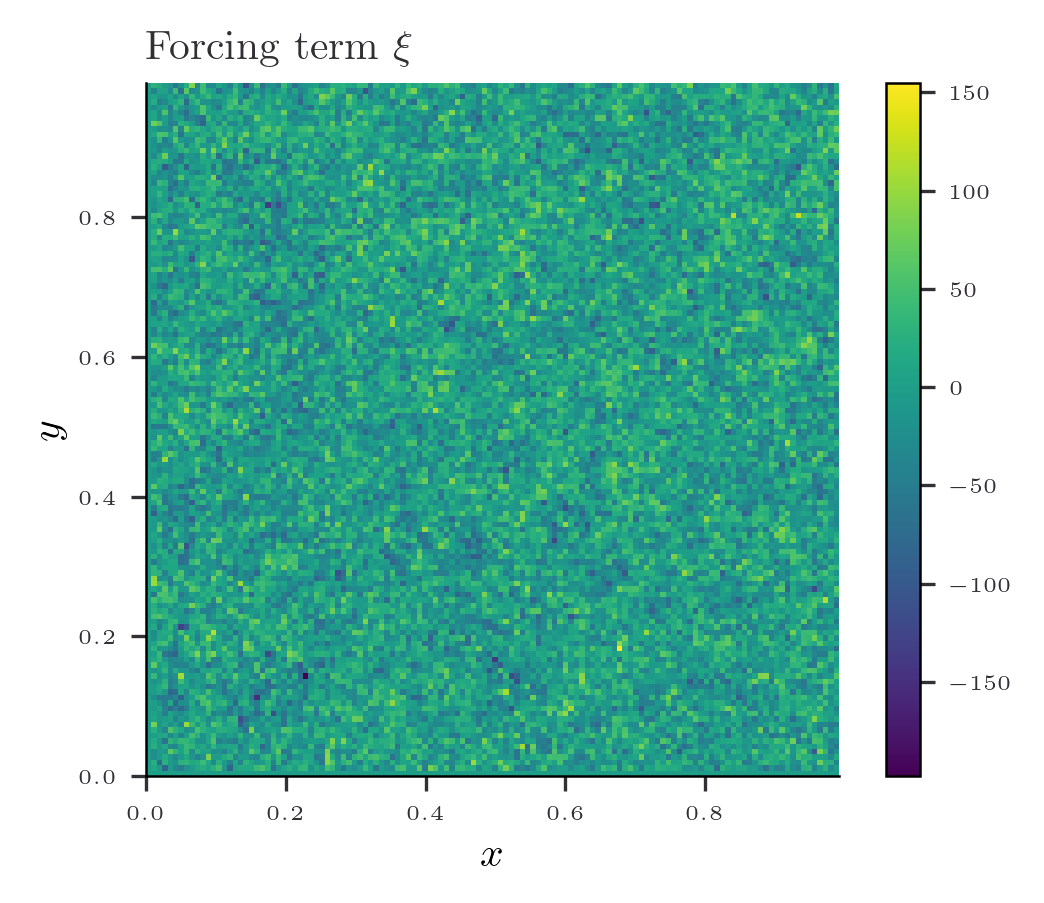

In [15]:
fig = plt.figure(figsize=(width, height))

plt.imshow(f_values[::-1, :], cmap='viridis', extent=[x_finest.min(), x_finest.max(), y_finest.min(), y_finest.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Forcing term $\xi$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

In [16]:
u_trans = dst_2d(u_values)
f_trans = dst_2d(f_values)
print(jnp.mean(jnp.abs(u_trans- coef_u)))

3.6245722661677274e-05


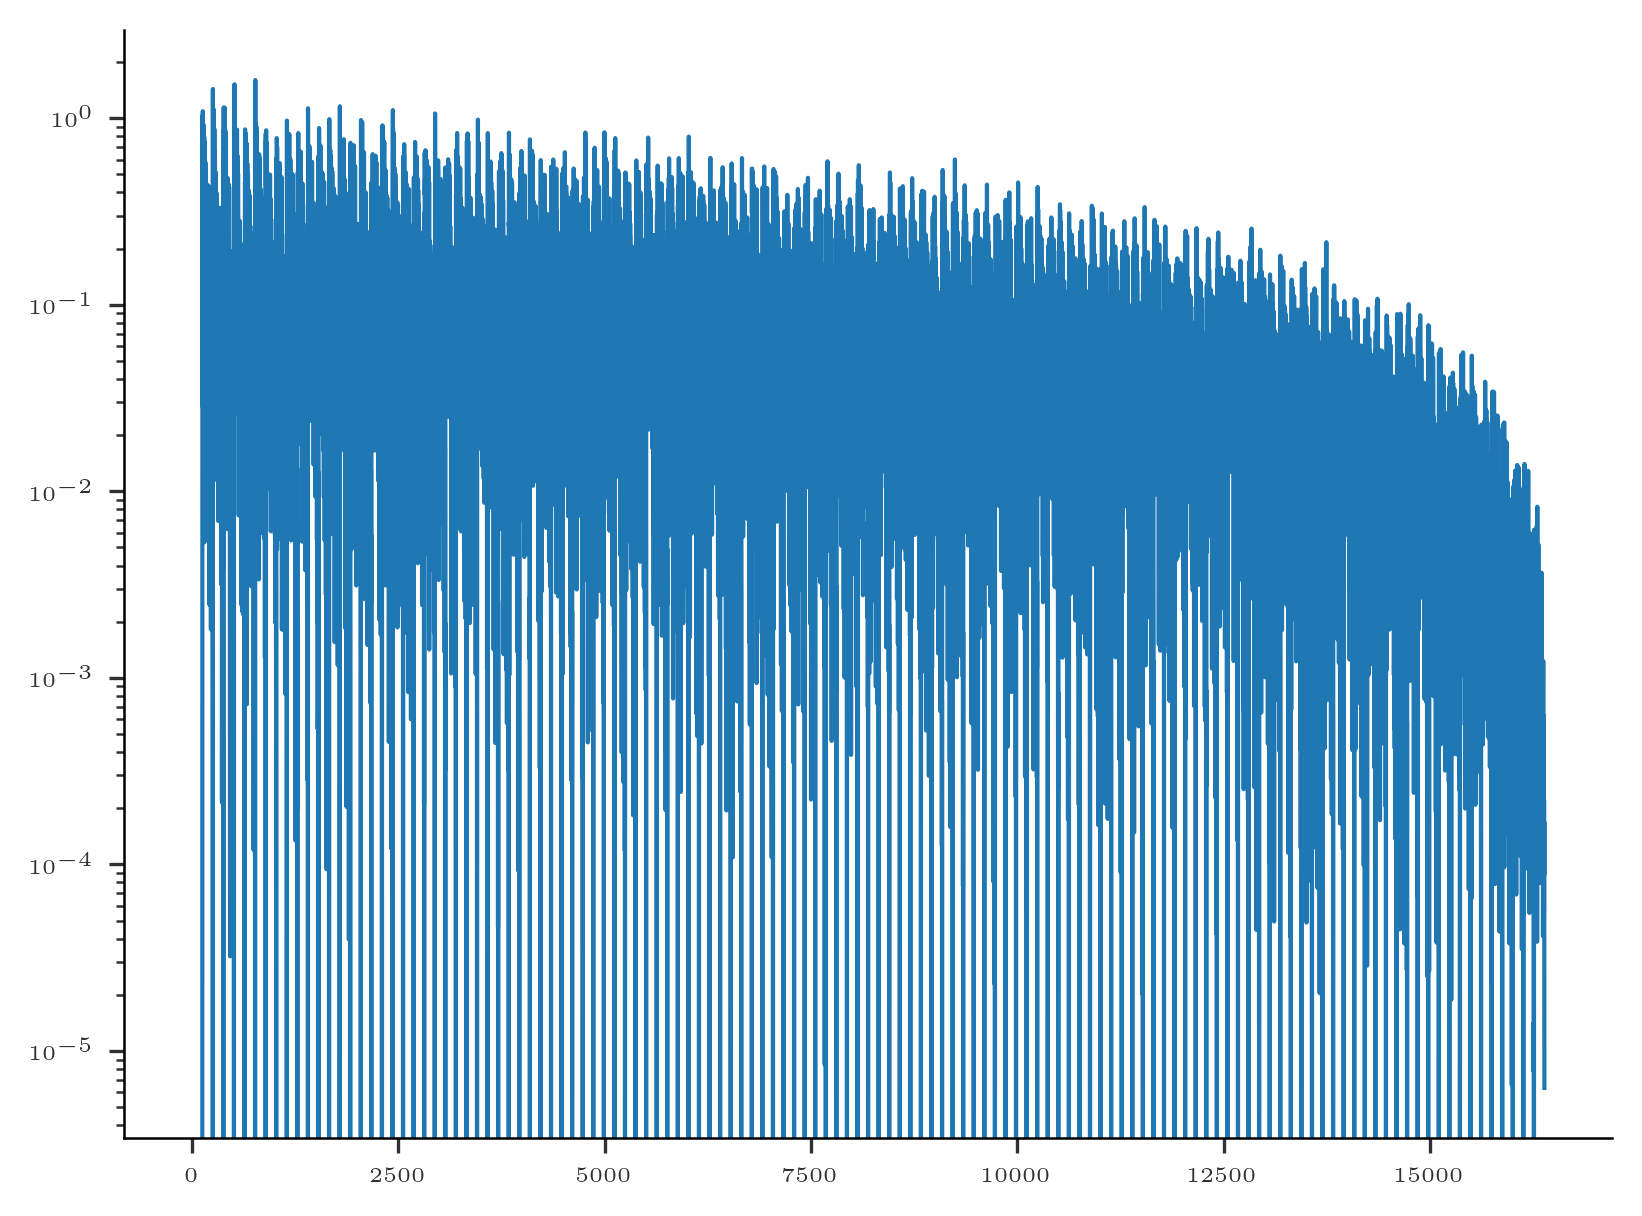

In [17]:
plt.plot(jnp.abs(f_trans.reshape(-1)), label = "f")
plt.yscale("log")
plt.show()

In [18]:
lower = 0.0
upper = 1.0
domain = jnp.array([lower,upper])


# 2d grid 
n_points = 2**6
print("Number of points {} ({} measurements)".format(n_points, n_points**2))
x = jnp.linspace(lower, upper, n_points, endpoint=False)
y = jnp.linspace(lower, upper, n_points, endpoint=False)
X, Y = jnp.meshgrid(x, y)

interior = create_interior(x, y)

Number of points 64 (4096 measurements)


In [19]:
# Create the boundary
n_boundary = 2**7
print("Number of boundary points: {} ({} total)".format(n_boundary, n_boundary*4))

# Create a boundary
# Boundary points
boundary = jnp.linspace(0,1, n_boundary)

boundary_points = []
# Creat a discretization of the boundary
for i in [0,1]:
    boundary_points.append(jnp.stack([jnp.zeros(n_boundary) + i, boundary], axis=-1))
for i in [0,1]:
    boundary_points.append(jnp.stack([boundary, jnp.zeros(n_boundary) + i], axis=-1))
    

boundary_points = jnp.concatenate(boundary_points, axis=0)
boundary_condition = jnp.zeros(shape = boundary_points.shape[0])

Number of boundary points: 128 (512 total)


# PINN solution

In [40]:
decay_nugget =  ((jnp.arange(0,n_points)[None]**2 + jnp.arange(0,n_points)[:,None]**2) + 1.0)**(-0.5)
#decay_nugget = (decay_nugget**(-0.5)).reshape(n_points*n_points)

In [41]:
decay_nugget

Array([[1.        , 0.70710678, 0.4472136 , ..., 0.01639124, 0.01612693,
        0.01587102],
       [0.70710678, 0.57735027, 0.40824829, ..., 0.01638904, 0.01612484,
        0.01586902],
       [0.4472136 , 0.40824829, 0.33333333, ..., 0.01638244, 0.01611855,
        0.01586303],
       ...,
       [0.01639124, 0.01638904, 0.01638244, ..., 0.01159114, 0.01149653,
        0.01140272],
       [0.01612693, 0.01612484, 0.01611855, ..., 0.01149653, 0.01140421,
        0.01131262],
       [0.01587102, 0.01586902, 0.01586303, ..., 0.01140272, 0.01131262,
        0.01122321]], dtype=float64, weak_type=True)

In [42]:
layer_sizes = [2, 64, 64,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))


# def nn_laplacian(params, x):
#     nabla = grad(predict, argnums = -1)
#     g_1, g_2 = nabla
# nn_laplacian = jit(grad(grad(predict), argnums=-1))

def laplacian(params, x):
    return jnp.trace(hessian(predict, argnums=-1)(params, x))

nn_laplacian = jit(vmap(laplacian, in_axes = (None, 0)))


# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, n_points, w = 1.0):
    u_grid = neural_network(params, grid).reshape(n_points, n_points)
    non_linearity = tau(u_grid)
    laplacian_grid = nn_laplacian(params, grid).reshape(n_points, n_points)
    # Compute the sine transform
    pred_sine = dst_2d(-nu*laplacian_grid + non_linearity)
    residual_interior = (pred_sine - f)*decay_nugget

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 4417 parameters in the neural network.


In [43]:
neural_network(params, interior).shape, nn_laplacian(params, interior).shape

((4096,), (4096,))

In [44]:
f_observed =  f_trans[:n_points,:n_points]

In [45]:
loss_fn(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points, w = 1.0)

Array(0.06557239, dtype=float64)

In [46]:
loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points, w = 1.0)
print(loss, grads)

0.0655723922283224 [(Array([[ 2.06034768e-03,  4.52995960e-03, -8.94928741e-03,
        -1.11508174e-02, -1.00823632e-02, -8.12865812e-03,
         9.68640391e-03,  4.10541693e-03, -2.72123654e-03,
        -1.90775454e-04,  4.25383104e-03, -1.99722528e-03,
        -8.43721379e-03, -7.04374334e-05, -2.63266097e-03,
        -2.96090160e-03, -5.28231205e-03, -6.71009071e-03,
         1.41220649e-04, -7.62742288e-04,  5.69123184e-03,
         2.59260001e-03, -1.96894144e-03,  3.95729234e-03,
        -1.18910915e-03,  2.07565218e-03, -5.57256002e-03,
         8.30775933e-04,  1.44055194e-03, -7.43774577e-03,
        -6.10598207e-03, -2.64240569e-04,  4.38856992e-04,
        -5.29337495e-03,  2.00547578e-03, -3.75796630e-03,
        -3.72924299e-04,  1.61403202e-03, -5.60443912e-03,
         4.84756850e-03, -3.59820019e-04, -1.82717536e-03,
        -4.16192677e-03, -5.94998505e-03, -5.10532490e-03,
         3.94680713e-05,  5.56599166e-03, -5.73158489e-03,
         2.93910680e-04,  2.0806769

In [47]:
# Define the optimizer
optimizer = optax.adaw(1e-3, weight_decay = 0.0)
opt_state = optimizer.init(params)

In [48]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [49]:
patience = 10**10  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0

In [50]:
loss_hist = []
num_epochs = 3e5
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
        best_param = params.copy()
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 0.0655724
Epoch 10000, Loss: 0.0002870
Epoch 20000, Loss: 0.0002415
Epoch 30000, Loss: 0.0001824
Epoch 40000, Loss: 0.0001653
Epoch 50000, Loss: 0.0001562
Epoch 60000, Loss: 0.0001454
Epoch 70000, Loss: 0.0001365
Epoch 80000, Loss: 0.0001267
Epoch 90000, Loss: 0.0001173
Epoch 100000, Loss: 0.0001061
Epoch 110000, Loss: 0.0000985
Epoch 120000, Loss: 0.0000933
Epoch 130000, Loss: 0.0000895
Epoch 140000, Loss: 0.0000864
Epoch 150000, Loss: 0.0000838
Epoch 160000, Loss: 0.0000838
Epoch 170000, Loss: 0.0000796
Epoch 180000, Loss: 0.0000801
Epoch 190000, Loss: 0.0000788
Epoch 200000, Loss: 0.0000751
Epoch 210000, Loss: 0.0000739
Epoch 220000, Loss: 0.0000728
Epoch 230000, Loss: 0.0000719
Epoch 240000, Loss: 0.0000712
Epoch 250000, Loss: 0.0000701
Epoch 260000, Loss: 0.0000694
Epoch 270000, Loss: 0.0000685
Epoch 280000, Loss: 0.0000676
Epoch 290000, Loss: 0.0000670


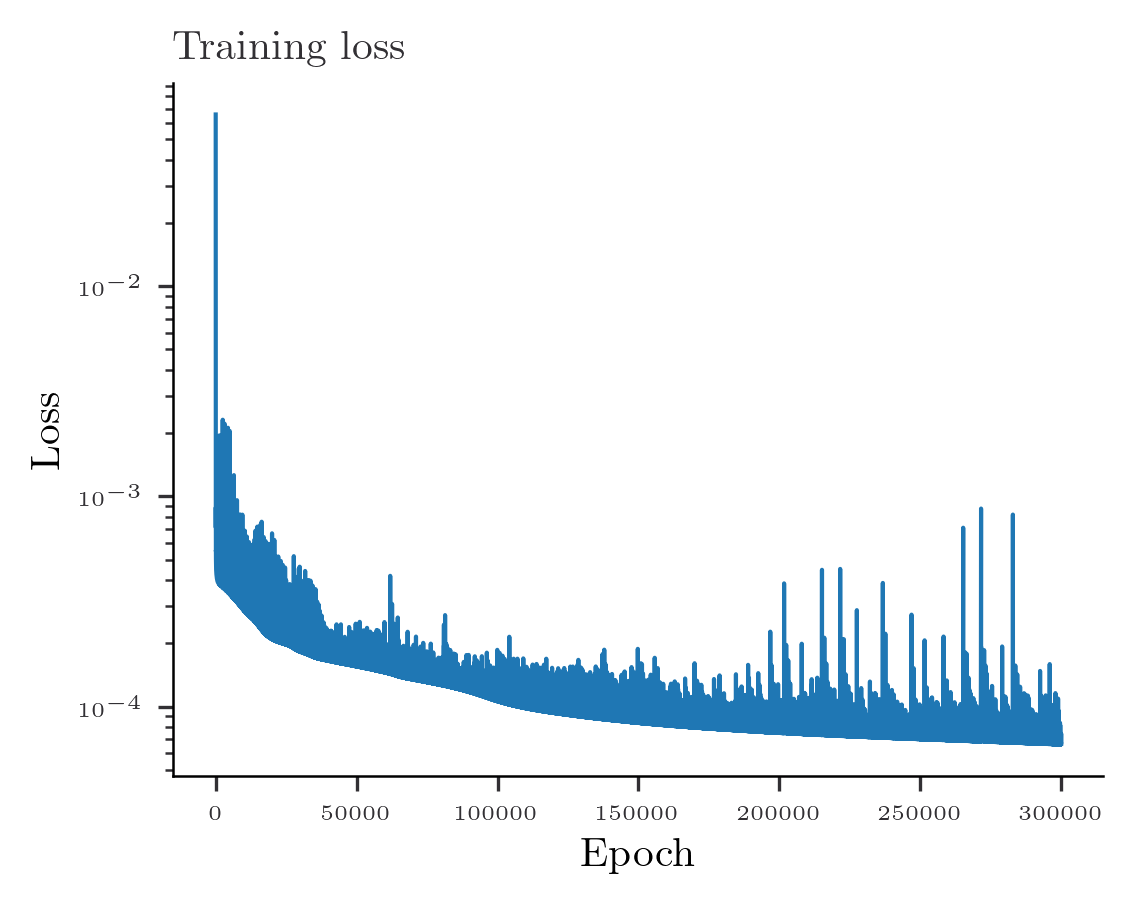

In [51]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

In [52]:
n_eval = n_coef
x_eval = jnp.linspace(lower, upper, n_eval)
y_eval = jnp.linspace(lower, upper, n_eval)
X, Y = jnp.meshgrid(x_eval, y_eval)
interior_eval = create_interior(x_eval, y_eval)
u_eval =evaluate_basis_sine_2d(x_eval,y_eval, coef_u)

In [53]:
pred_grid = neural_network(params, interior_eval).reshape(n_eval, n_eval)

In [54]:
print(compute_2d_error(pred_grid, u_eval, x_eval, y_eval))

(Array(0.03309001, dtype=float64), Array(0.10187265, dtype=float64))


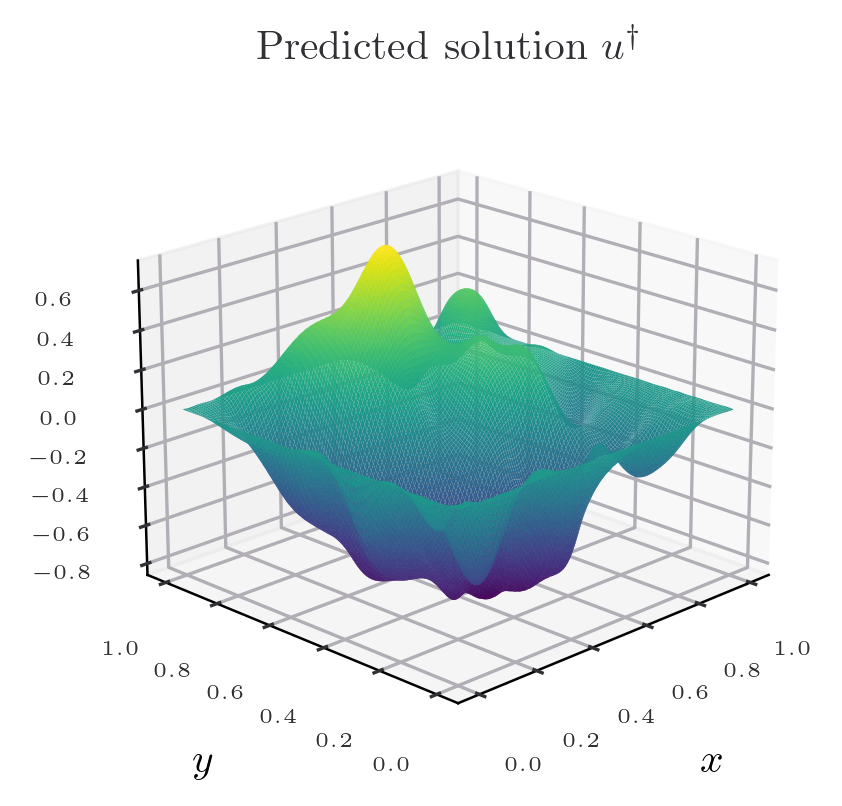

In [55]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

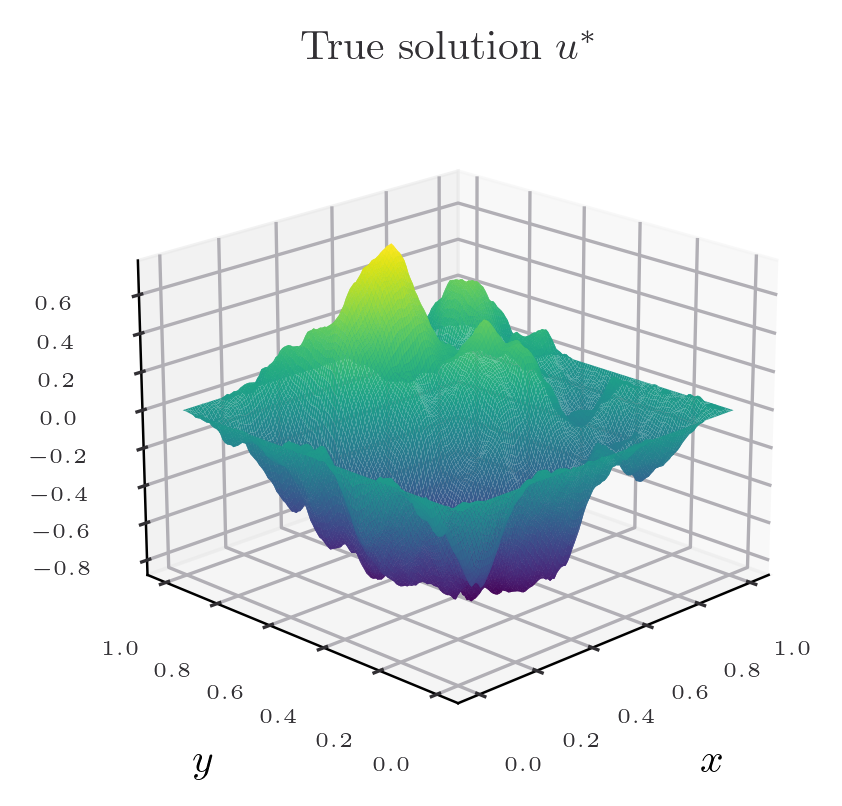

In [56]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_eval,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

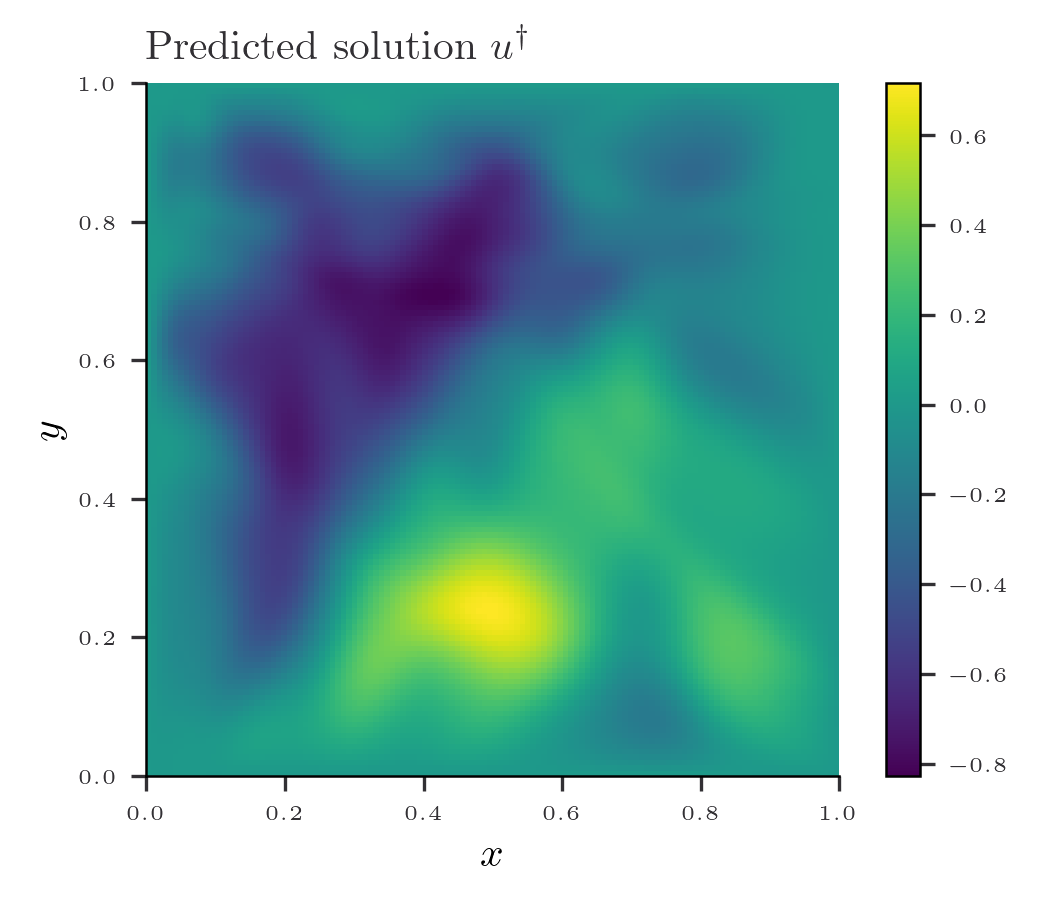

In [57]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_grid, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Predicted solution $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

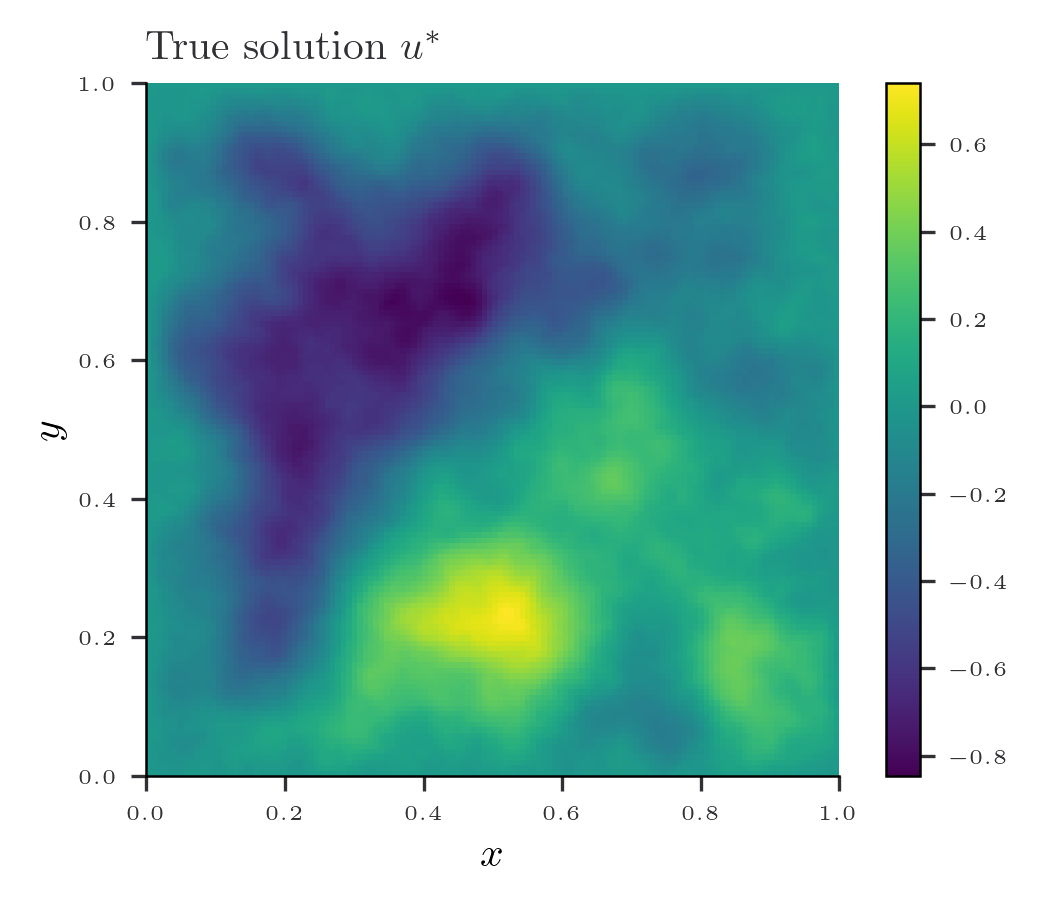

In [58]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

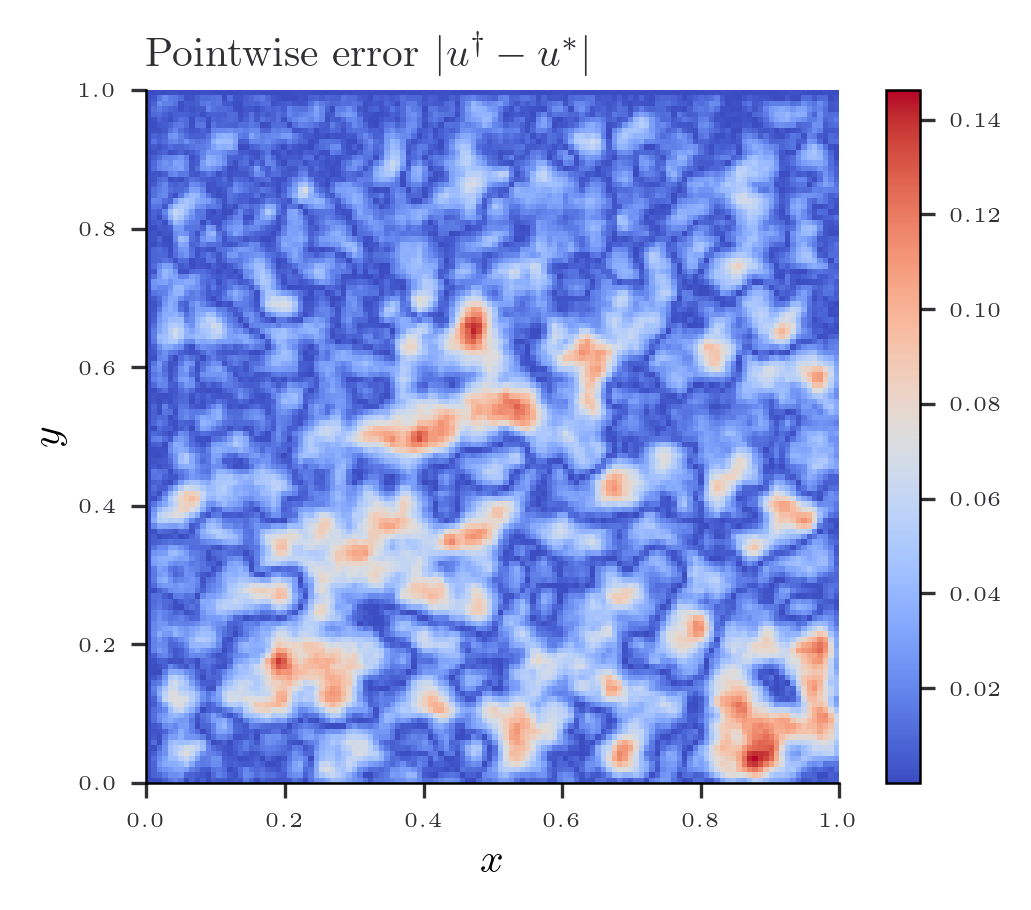

In [59]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_grid - u_values), cmap='coolwarm', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# $\ell^2$ regularization on the weights

In [ ]:
decay_nugget =  ((jnp.arange(0,n_points)[None]**2 + jnp.arange(0,n_points)[:,None]**2) + 1.0)**(-0.5)

In [ ]:
decay_nugget

Array([[1.        , 0.70710678, 0.4472136 , ..., 0.01639124, 0.01612693,
        0.01587102],
       [0.70710678, 0.57735027, 0.40824829, ..., 0.01638904, 0.01612484,
        0.01586902],
       [0.4472136 , 0.40824829, 0.33333333, ..., 0.01638244, 0.01611855,
        0.01586303],
       ...,
       [0.01639124, 0.01638904, 0.01638244, ..., 0.01159114, 0.01149653,
        0.01140272],
       [0.01612693, 0.01612484, 0.01611855, ..., 0.01149653, 0.01140421,
        0.01131262],
       [0.01587102, 0.01586902, 0.01586303, ..., 0.01140272, 0.01131262,
        0.01122321]], dtype=float64, weak_type=True)

In [ ]:
layer_sizes = [2, 64, 64,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))


# def nn_laplacian(params, x):
#     nabla = grad(predict, argnums = -1)
#     g_1, g_2 = nabla
# nn_laplacian = jit(grad(grad(predict), argnums=-1))

def laplacian(params, x):
    return jnp.trace(hessian(predict, argnums=-1)(params, x))

nn_laplacian = jit(vmap(laplacian, in_axes = (None, 0)))


# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, n_points, w = 1.0):
    u_grid = neural_network(params, grid).reshape(n_points, n_points)
    non_linearity = tau(u_grid)
    laplacian_grid = nn_laplacian(params, grid).reshape(n_points, n_points)
    # Compute the sine transform
    pred_sine = dst_2d(-nu*laplacian_grid + non_linearity)
    residual_interior = (pred_sine - f)*decay_nugget

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 4417 parameters in the neural network.


In [ ]:
f_observed =  f_trans[:n_points,:n_points]

In [ ]:
loss_fn(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points, w = 1.0)

Array(0.06557239, dtype=float64)

In [ ]:
loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points, w = 1.0)
print(loss, grads)

0.0655723922283224 [(Array([[ 2.06034768e-03,  4.52995960e-03, -8.94928741e-03,
        -1.11508174e-02, -1.00823632e-02, -8.12865812e-03,
         9.68640391e-03,  4.10541693e-03, -2.72123654e-03,
        -1.90775454e-04,  4.25383104e-03, -1.99722528e-03,
        -8.43721379e-03, -7.04374334e-05, -2.63266097e-03,
        -2.96090160e-03, -5.28231205e-03, -6.71009071e-03,
         1.41220649e-04, -7.62742288e-04,  5.69123184e-03,
         2.59260001e-03, -1.96894144e-03,  3.95729234e-03,
        -1.18910915e-03,  2.07565218e-03, -5.57256002e-03,
         8.30775933e-04,  1.44055194e-03, -7.43774577e-03,
        -6.10598207e-03, -2.64240569e-04,  4.38856992e-04,
        -5.29337495e-03,  2.00547578e-03, -3.75796630e-03,
        -3.72924299e-04,  1.61403202e-03, -5.60443912e-03,
         4.84756850e-03, -3.59820019e-04, -1.82717536e-03,
        -4.16192677e-03, -5.94998505e-03, -5.10532490e-03,
         3.94680713e-05,  5.56599166e-03, -5.73158489e-03,
         2.93910680e-04,  2.0806769

In [ ]:
# Define the optimizer
optimizer = optax.adamw(1e-3, weight_decay = 1e-6)
opt_state = optimizer.init(params)

In [ ]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [ ]:
patience = 10**10  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0

In [ ]:
loss_hist = []
num_epochs = 3e5
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
        best_param = params.copy()
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 0.0655724
Epoch 10000, Loss: 0.0002880
Epoch 20000, Loss: 0.0002096
Epoch 30000, Loss: 0.0001828
Epoch 40000, Loss: 0.0001662
Epoch 50000, Loss: 0.0001761
Epoch 60000, Loss: 0.0001458
Epoch 70000, Loss: 0.0001655
Epoch 80000, Loss: 0.0001267
Epoch 90000, Loss: 0.0001183
Epoch 100000, Loss: 0.0001075
Epoch 110000, Loss: 0.0000983
Epoch 120000, Loss: 0.0000936
Epoch 130000, Loss: 0.0000899
Epoch 140000, Loss: 0.0000869
Epoch 150000, Loss: 0.0000843
Epoch 160000, Loss: 0.0000820
Epoch 170000, Loss: 0.0000797
Epoch 180000, Loss: 0.0000778
Epoch 190000, Loss: 0.0000762
Epoch 200000, Loss: 0.0000762
Epoch 210000, Loss: 0.0000742
Epoch 220000, Loss: 0.0000729
Epoch 230000, Loss: 0.0000716
Epoch 240000, Loss: 0.0001165
Epoch 250000, Loss: 0.0000759
Epoch 260000, Loss: 0.0000691
Epoch 270000, Loss: 0.0000683
Epoch 280000, Loss: 0.0000678
Epoch 290000, Loss: 0.0000667


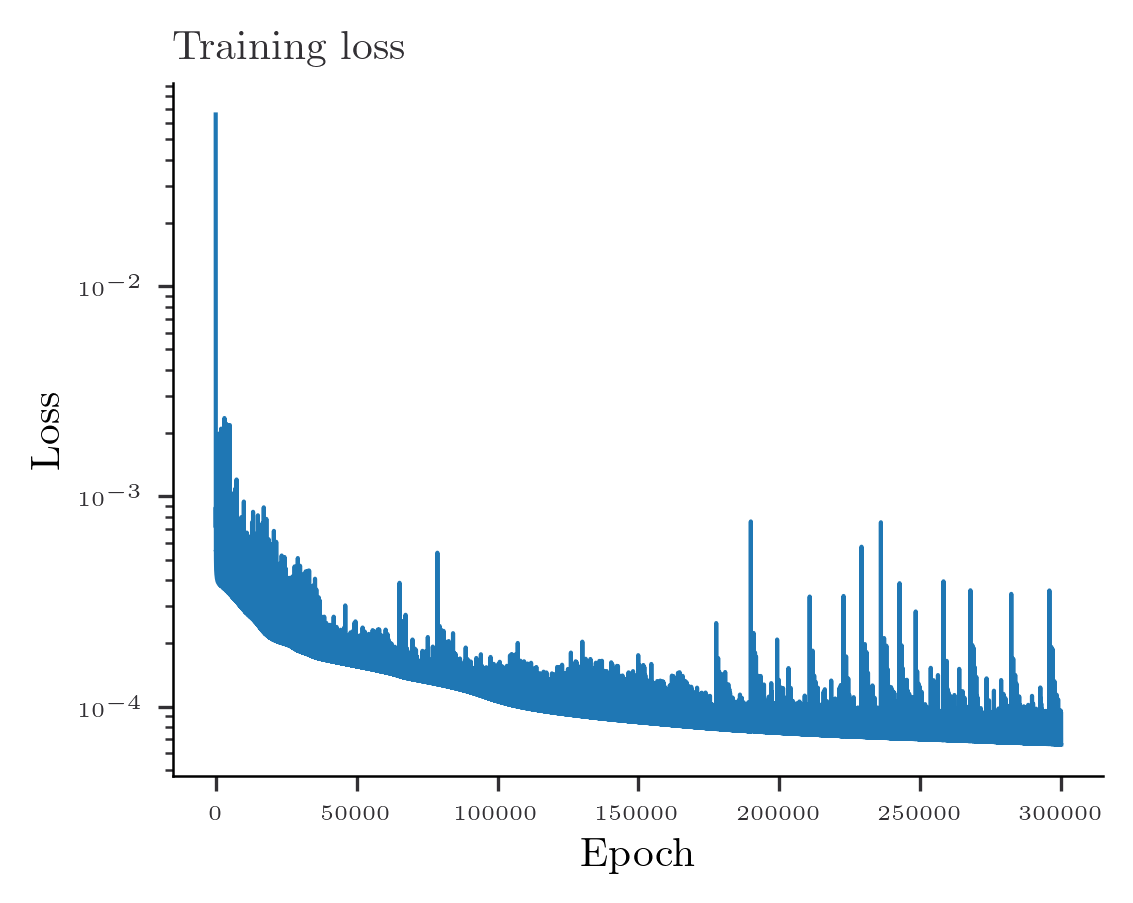

In [ ]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

In [ ]:
n_eval = n_coef
x_eval = jnp.linspace(lower, upper, n_eval)
y_eval = jnp.linspace(lower, upper, n_eval)
X, Y = jnp.meshgrid(x_eval, y_eval)
interior_eval = create_interior(x_eval, y_eval)
u_eval =evaluate_basis_sine_2d(x_eval,y_eval, coef_u)

In [ ]:
pred_grid = neural_network(params, interior_eval).reshape(n_eval, n_eval)

In [ ]:
print(compute_2d_error(pred_grid, u_eval, x_eval, y_eval))

(Array(0.0330172, dtype=float64), Array(0.1016485, dtype=float64))


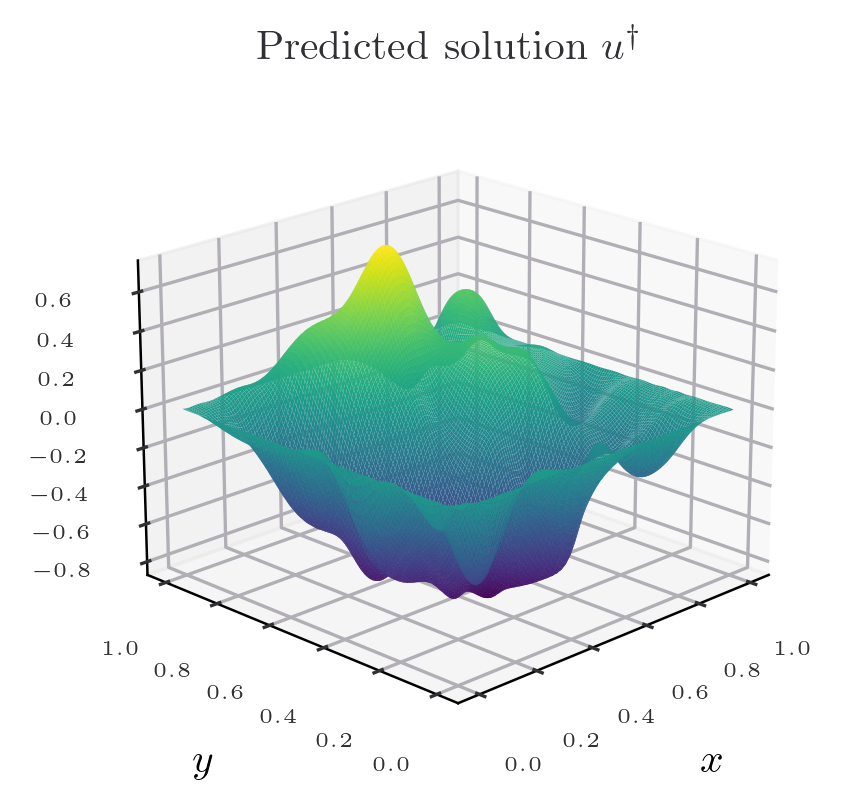

In [ ]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

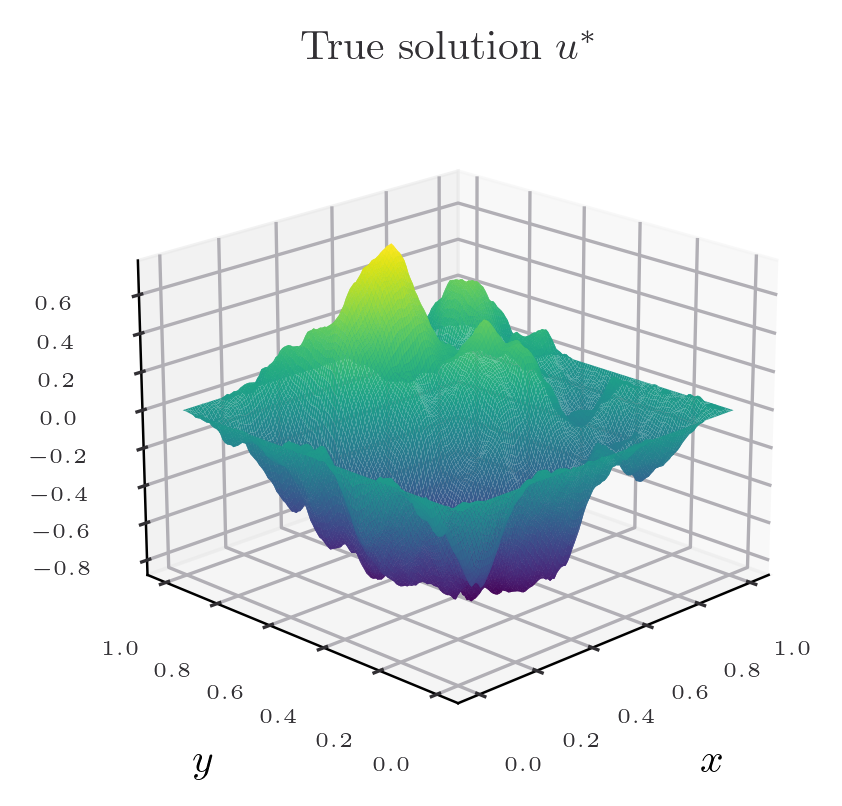

In [ ]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_eval,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

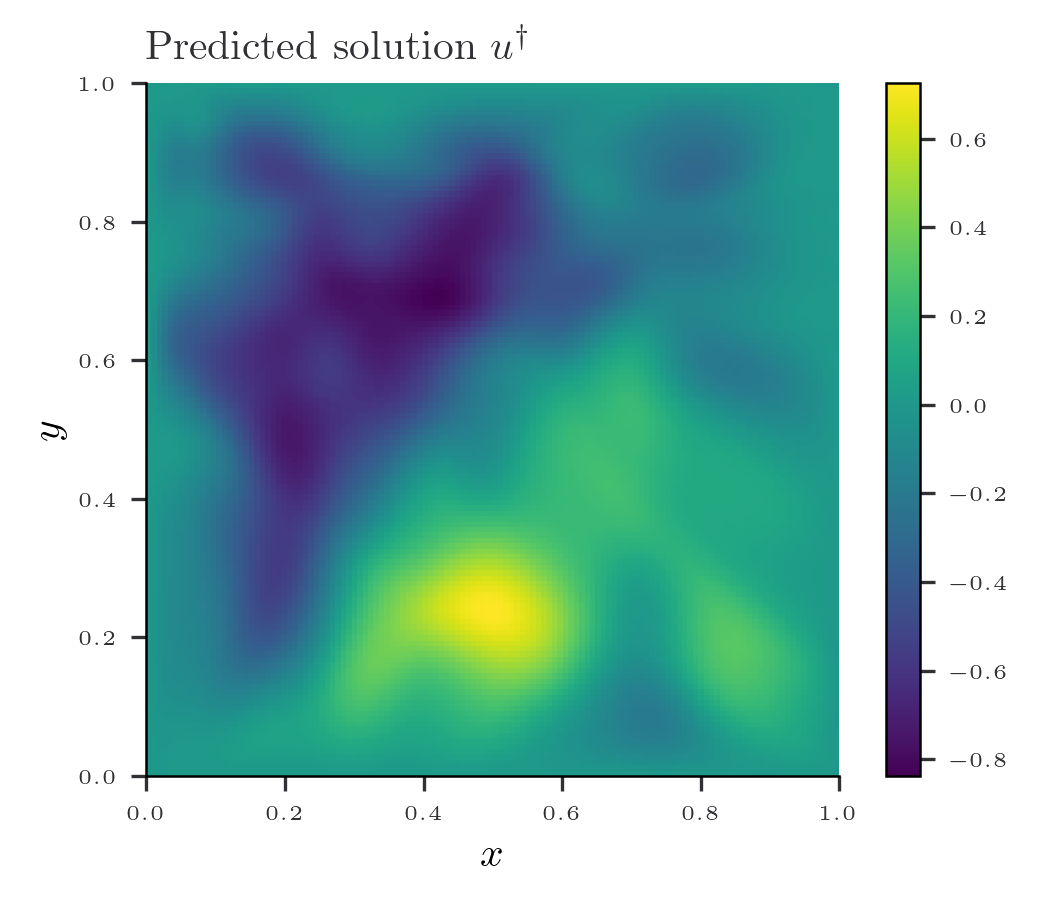

In [ ]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_grid, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Predicted solution $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

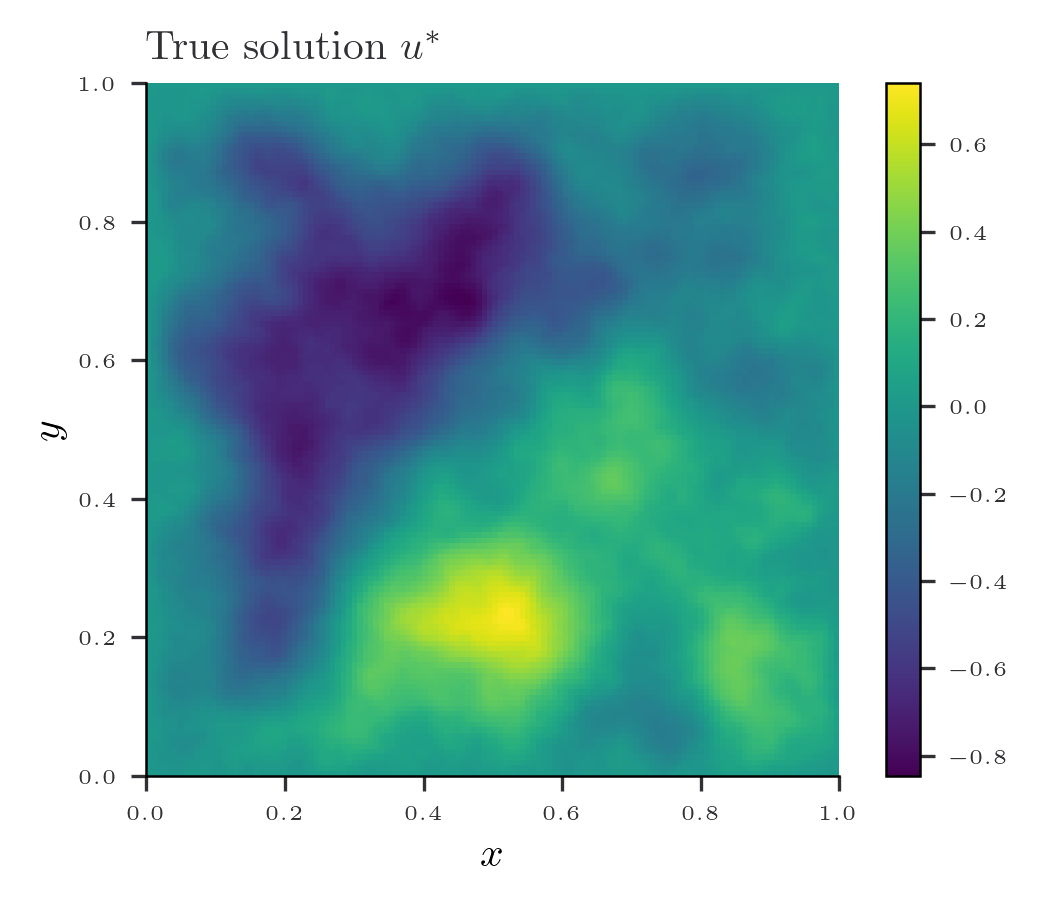

In [ ]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

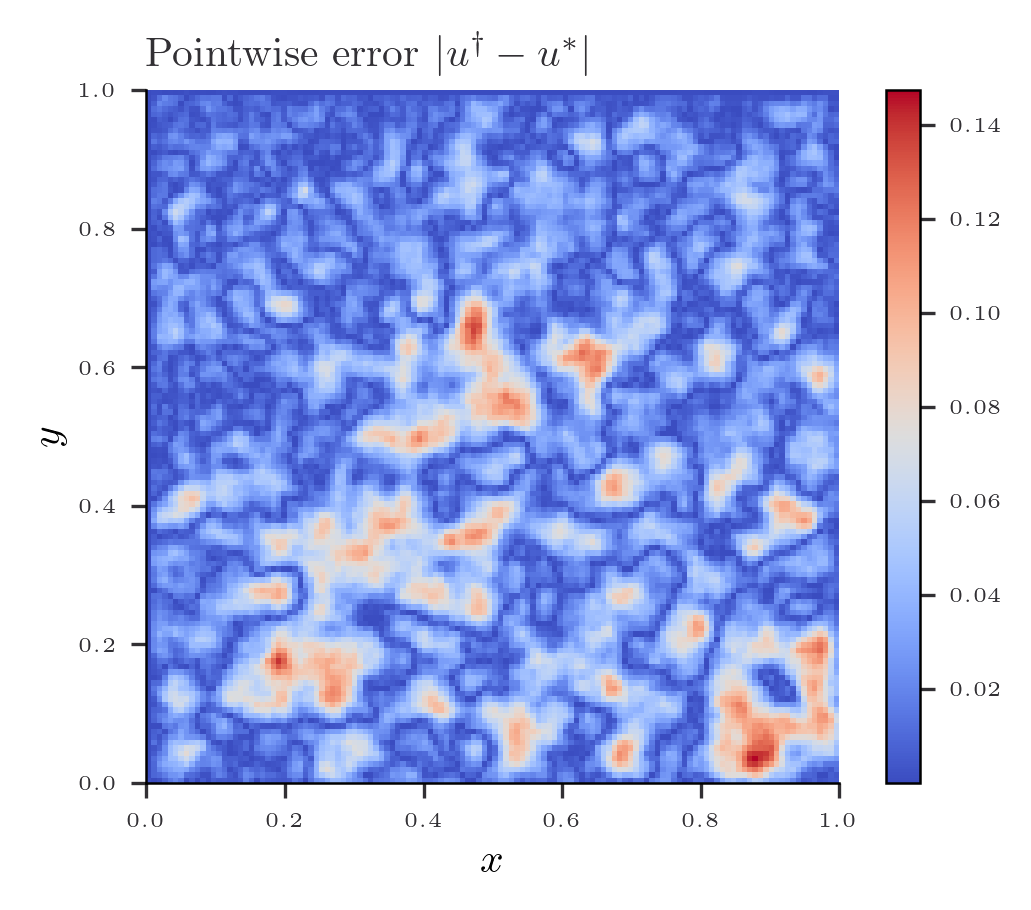

In [ ]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_grid - u_values), cmap='coolwarm', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# $L^2$ norm

In [104]:
layer_sizes = [2, 64, 64,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))


# def nn_laplacian(params, x):
#     nabla = grad(predict, argnums = -1)
#     g_1, g_2 = nabla
# nn_laplacian = jit(grad(grad(predict), argnums=-1))

def laplacian(params, x):
    return jnp.trace(hessian(predict, argnums=-1)(params, x))

nn_laplacian = jit(vmap(laplacian, in_axes = (None, 0)))


# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, n_points, w = 1.0):
    u_grid = neural_network(params, grid).reshape(n_points, n_points)
    non_linearity = tau(u_grid)
    laplacian_grid = nn_laplacian(params, grid).reshape(n_points, n_points)
    # Compute the sine transform
    pred_sine = dst_2d(-nu*laplacian_grid + non_linearity)
    residual_interior = (pred_sine - f)

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 4417 parameters in the neural network.


In [105]:
f_observed =  f_trans[:n_points,:n_points]

In [106]:
loss_fn(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points, w = 1.0)

Array(0.1429061, dtype=float64)

In [107]:
loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points, w = 1.0)
print(loss, grads)

0.14290609586229758 [(Array([[ 2.06176035e-03,  4.50122239e-03, -8.97447205e-03,
        -1.11702131e-02, -1.00695391e-02, -8.14631997e-03,
         9.70463762e-03,  4.08054266e-03, -2.70373995e-03,
        -1.47408070e-04,  4.21321862e-03, -1.97135073e-03,
        -8.45282553e-03, -6.36238422e-05, -2.63095656e-03,
        -2.99917799e-03, -5.28776691e-03, -6.69463666e-03,
         1.78511739e-04, -7.66750394e-04,  5.72717245e-03,
         2.57528999e-03, -1.97325296e-03,  3.94299448e-03,
        -1.16427823e-03,  2.06500355e-03, -5.54347842e-03,
         8.04860724e-04,  1.46819748e-03, -7.44414312e-03,
        -6.13026072e-03, -2.75351455e-04,  4.15772140e-04,
        -5.32633153e-03,  1.98846139e-03, -3.81058158e-03,
        -3.88547180e-04,  1.68926396e-03, -5.54410362e-03,
         4.82210916e-03, -3.55729000e-04, -1.77460976e-03,
        -4.22344517e-03, -5.95790895e-03, -5.10381737e-03,
         6.72353609e-05,  5.55818803e-03, -5.73501715e-03,
         2.67953641e-04,  2.108227

In [108]:
# Define the optimizer
optimizer = optax.adamw(1e-3, weight_decay = 0.0)
opt_state = optimizer.init(params)

In [109]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [110]:
patience = 10**10  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0

In [111]:
loss_hist = []
num_epochs = 3e5
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
        best_param = params.copy()
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 0.1429061
Epoch 10000, Loss: 0.0683551
Epoch 20000, Loss: 0.0571268
Epoch 30000, Loss: 0.0507640
Epoch 40000, Loss: 0.0460798
Epoch 50000, Loss: 0.0427387
Epoch 60000, Loss: 0.0402110
Epoch 70000, Loss: 0.0387716
Epoch 80000, Loss: 0.0376829
Epoch 90000, Loss: 0.0364760
Epoch 100000, Loss: 0.0354226
Epoch 110000, Loss: 0.0342823
Epoch 120000, Loss: 0.0332648
Epoch 130000, Loss: 0.0324650
Epoch 140000, Loss: 0.0320126
Epoch 150000, Loss: 0.0310601
Epoch 160000, Loss: 0.0304840
Epoch 170000, Loss: 0.0299000
Epoch 180000, Loss: 0.0294024
Epoch 190000, Loss: 0.0288611
Epoch 200000, Loss: 0.0284329
Epoch 210000, Loss: 0.0280634
Epoch 220000, Loss: 0.0278074
Epoch 230000, Loss: 0.0276057
Epoch 240000, Loss: 0.0272731
Epoch 250000, Loss: 0.0269361
Epoch 260000, Loss: 0.0266874
Epoch 270000, Loss: 0.0264641
Epoch 280000, Loss: 0.0262840
Epoch 290000, Loss: 0.0260450


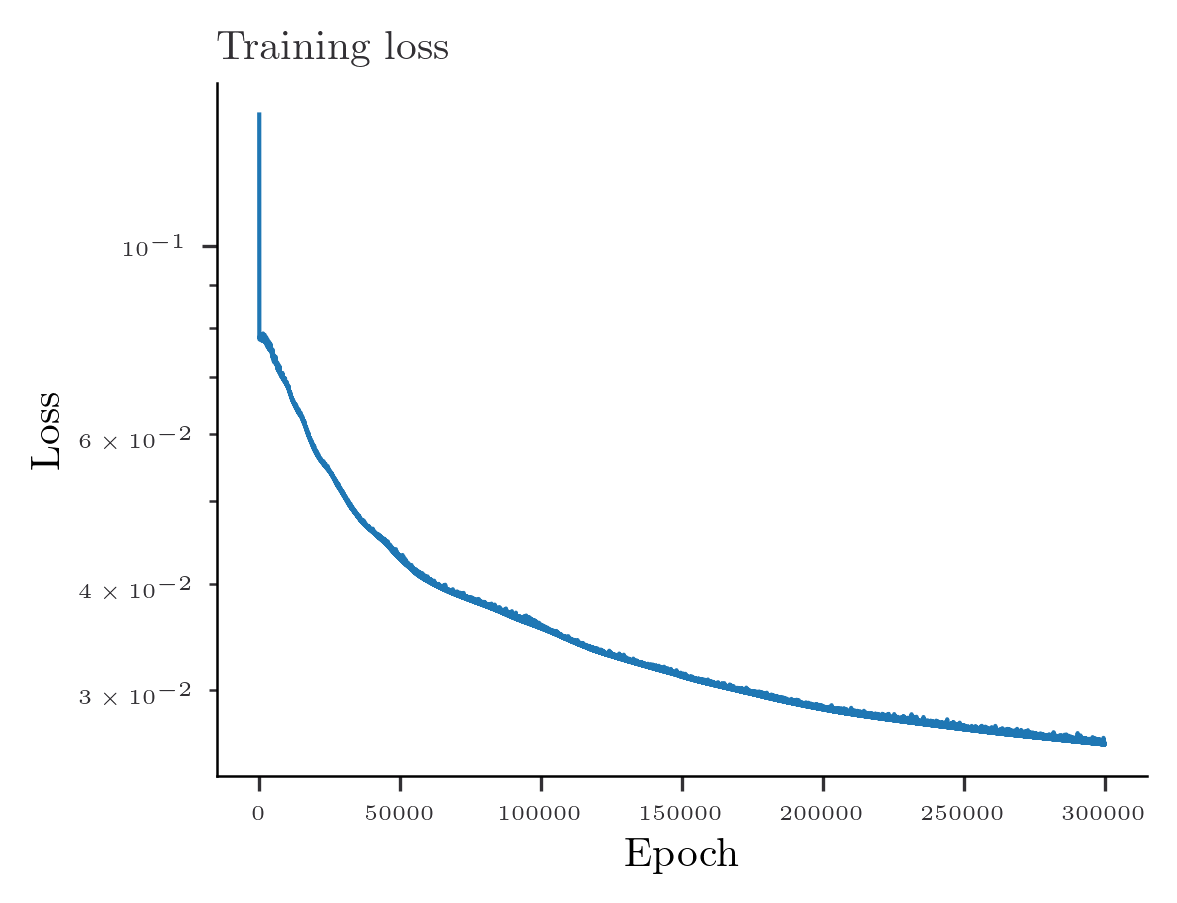

In [112]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

In [113]:
n_eval = n_coef
x_eval = jnp.linspace(lower, upper, n_eval)
y_eval = jnp.linspace(lower, upper, n_eval)
X, Y = jnp.meshgrid(x_eval, y_eval)
interior_eval = create_interior(x_eval, y_eval)
u_eval =evaluate_basis_sine_2d(x_eval,y_eval, coef_u)

In [114]:
pred_grid = neural_network(params, interior_eval).reshape(n_eval, n_eval)

In [115]:
print(compute_2d_error(pred_grid, u_eval, x_eval, y_eval))

(Array(0.12915399, dtype=float64), Array(0.39762032, dtype=float64))


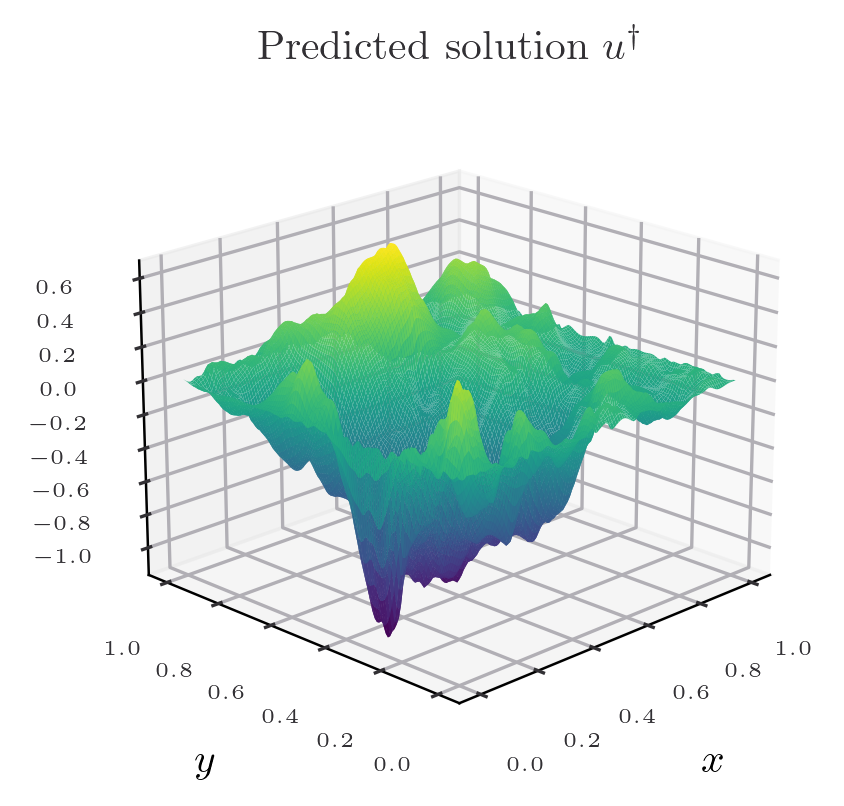

In [116]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

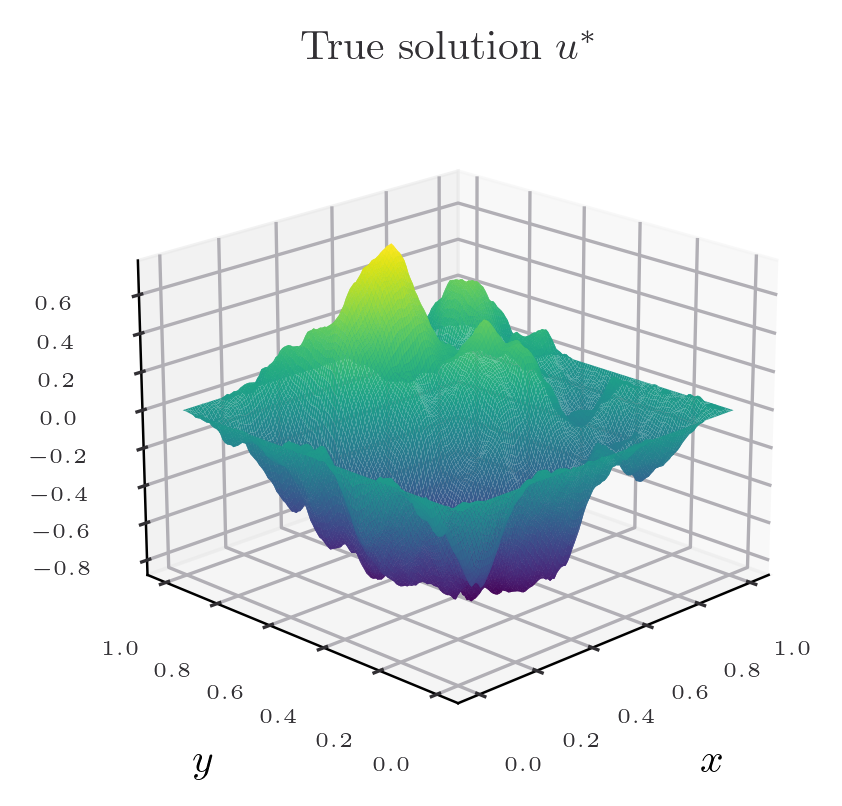

In [117]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_eval,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

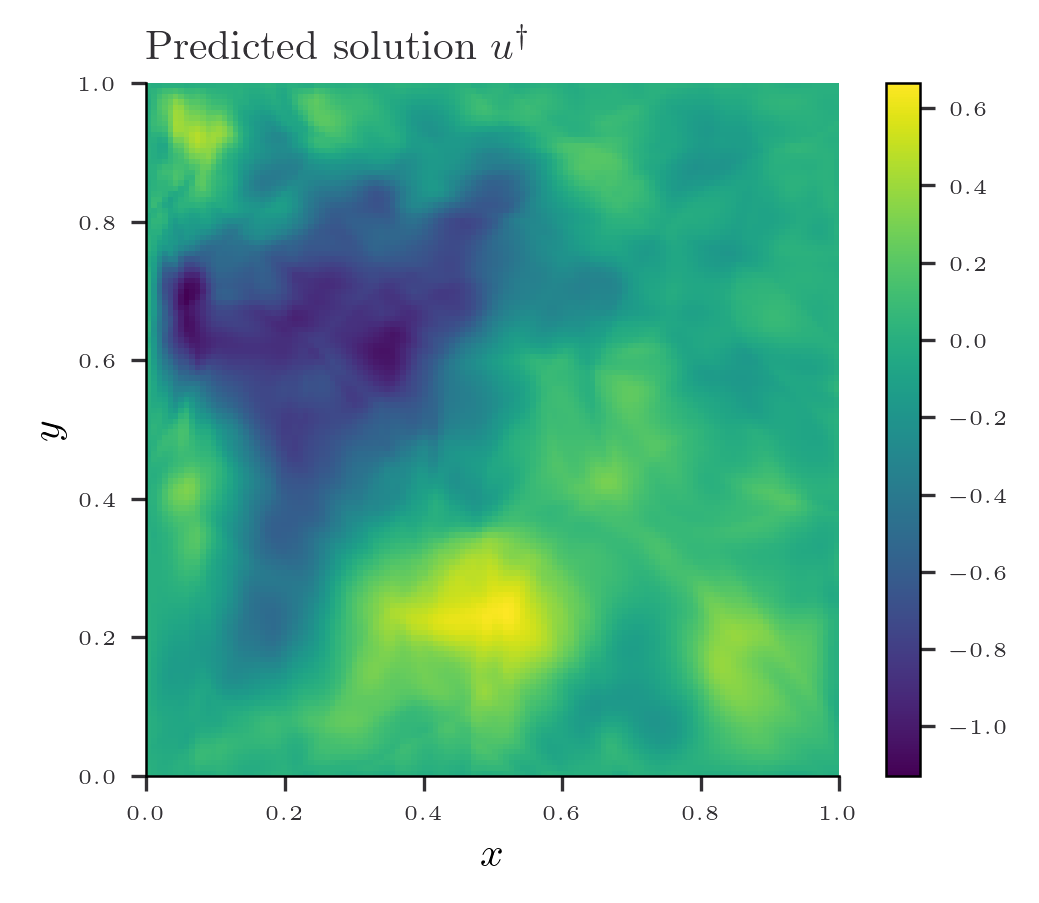

In [118]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_grid, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Predicted solution $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

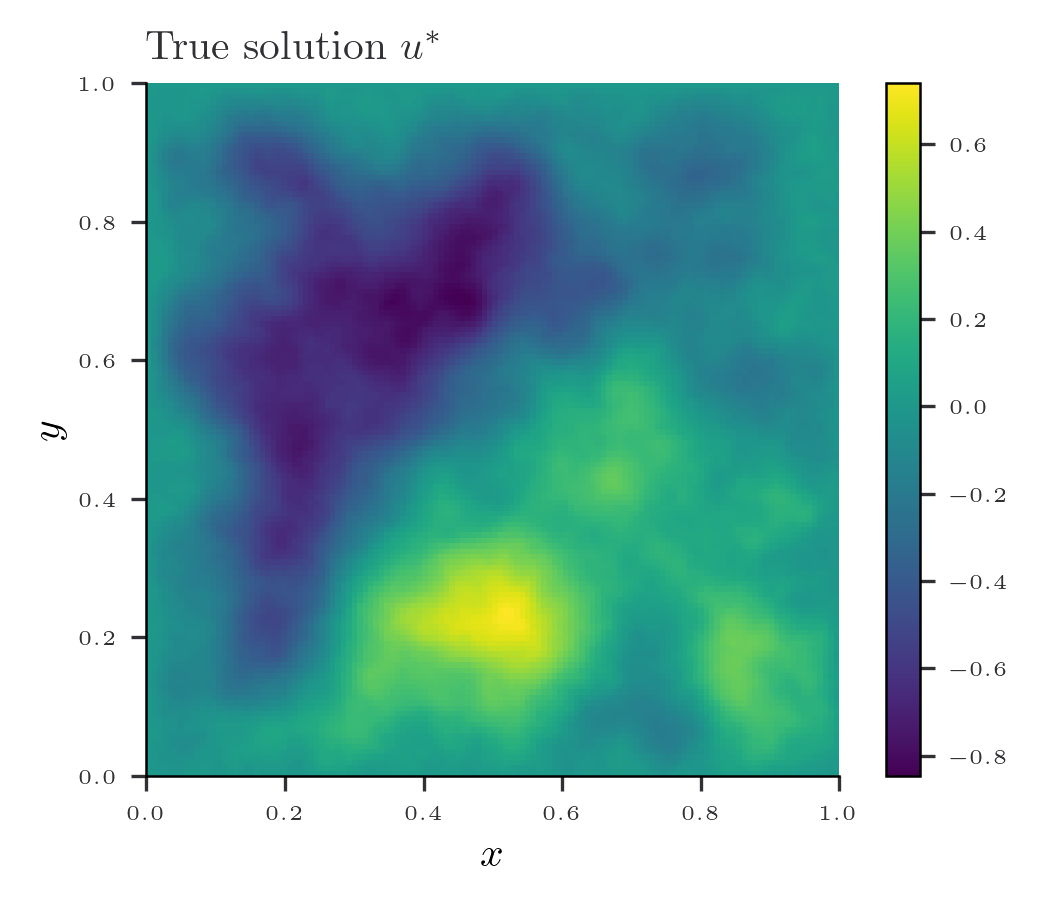

In [119]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

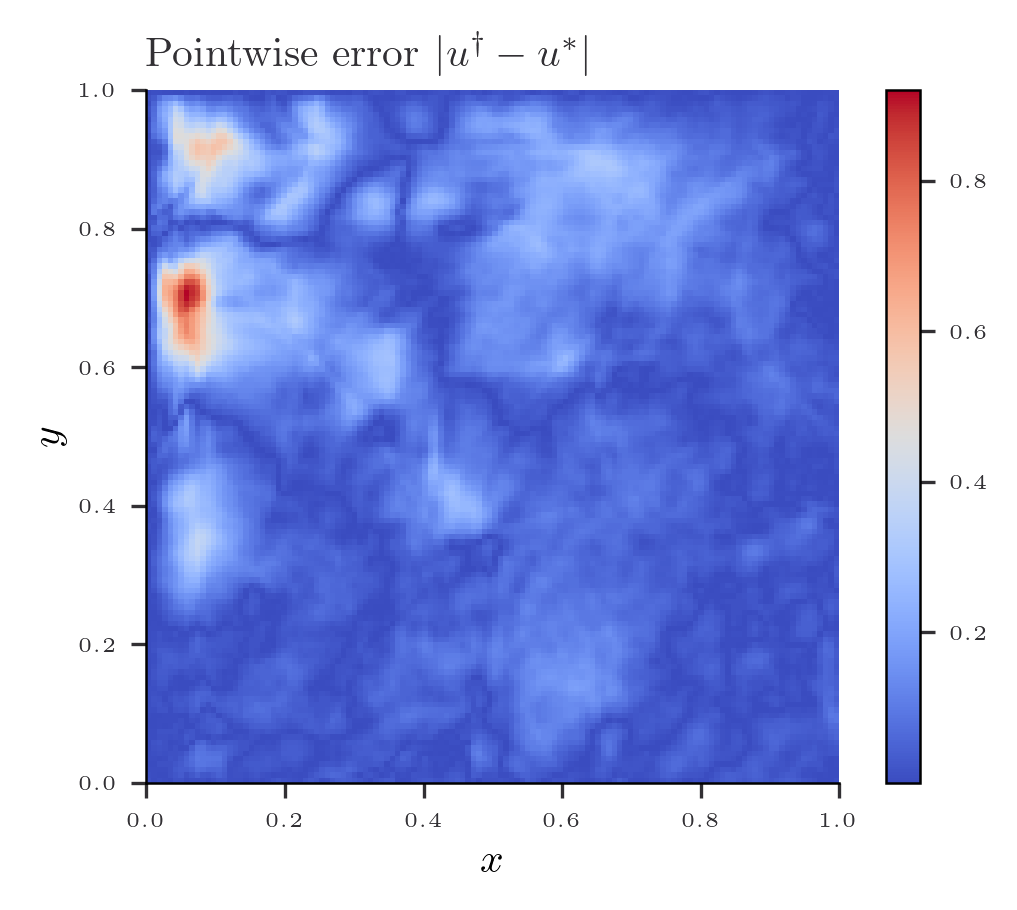

In [120]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_grid - u_values), cmap='coolwarm', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# $L^2$ norm + $\ell^2$ regularization

In [131]:
layer_sizes = [2, 64, 64,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))


# def nn_laplacian(params, x):
#     nabla = grad(predict, argnums = -1)
#     g_1, g_2 = nabla
# nn_laplacian = jit(grad(grad(predict), argnums=-1))

def laplacian(params, x):
    return jnp.trace(hessian(predict, argnums=-1)(params, x))

nn_laplacian = jit(vmap(laplacian, in_axes = (None, 0)))


# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, n_points, w = 1.0):
    u_grid = neural_network(params, grid).reshape(n_points, n_points)
    non_linearity = tau(u_grid)
    laplacian_grid = nn_laplacian(params, grid).reshape(n_points, n_points)
    # Compute the sine transform
    pred_sine = dst_2d(-nu*laplacian_grid + non_linearity)
    residual_interior = (pred_sine - f)

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 4417 parameters in the neural network.


In [132]:
f_observed =  f_trans[:n_points,:n_points]

In [133]:
loss_fn(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points, w = 1.0)

Array(0.1429061, dtype=float64)

In [134]:
loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points, w = 1.0)
print(loss, grads)

0.14290609586229758 [(Array([[ 2.06176035e-03,  4.50122239e-03, -8.97447205e-03,
        -1.11702131e-02, -1.00695391e-02, -8.14631997e-03,
         9.70463762e-03,  4.08054266e-03, -2.70373995e-03,
        -1.47408070e-04,  4.21321862e-03, -1.97135073e-03,
        -8.45282553e-03, -6.36238422e-05, -2.63095656e-03,
        -2.99917799e-03, -5.28776691e-03, -6.69463666e-03,
         1.78511739e-04, -7.66750394e-04,  5.72717245e-03,
         2.57528999e-03, -1.97325296e-03,  3.94299448e-03,
        -1.16427823e-03,  2.06500355e-03, -5.54347842e-03,
         8.04860724e-04,  1.46819748e-03, -7.44414312e-03,
        -6.13026072e-03, -2.75351455e-04,  4.15772140e-04,
        -5.32633153e-03,  1.98846139e-03, -3.81058158e-03,
        -3.88547180e-04,  1.68926396e-03, -5.54410362e-03,
         4.82210916e-03, -3.55729000e-04, -1.77460976e-03,
        -4.22344517e-03, -5.95790895e-03, -5.10381737e-03,
         6.72353609e-05,  5.55818803e-03, -5.73501715e-03,
         2.67953641e-04,  2.108227

In [135]:
# Define the optimizer
optimizer = optax.adamw(1e-3, weight_decay = 1e-6)
opt_state = optimizer.init(params)

In [136]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [137]:
patience = 10**10  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0

In [138]:
loss_hist = []
num_epochs = 3e5
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
        best_param = params.copy()
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 0.1429061
Epoch 10000, Loss: 0.0683331
Epoch 20000, Loss: 0.0582640
Epoch 30000, Loss: 0.0503677
Epoch 40000, Loss: 0.0465588
Epoch 50000, Loss: 0.0434571
Epoch 60000, Loss: 0.0410206
Epoch 70000, Loss: 0.0389001
Epoch 80000, Loss: 0.0372685
Epoch 90000, Loss: 0.0363389
Epoch 100000, Loss: 0.0356715
Epoch 110000, Loss: 0.0350050
Epoch 120000, Loss: 0.0344625
Epoch 130000, Loss: 0.0339370
Epoch 140000, Loss: 0.0333257
Epoch 150000, Loss: 0.0328231
Epoch 160000, Loss: 0.0323574
Epoch 170000, Loss: 0.0319386
Epoch 180000, Loss: 0.0315830
Epoch 190000, Loss: 0.0311337
Epoch 200000, Loss: 0.0308374
Epoch 210000, Loss: 0.0304264
Epoch 220000, Loss: 0.0302064
Epoch 230000, Loss: 0.0297900
Epoch 240000, Loss: 0.0294373
Epoch 250000, Loss: 0.0291246
Epoch 260000, Loss: 0.0288329
Epoch 270000, Loss: 0.0284887
Epoch 280000, Loss: 0.0282752
Epoch 290000, Loss: 0.0280212


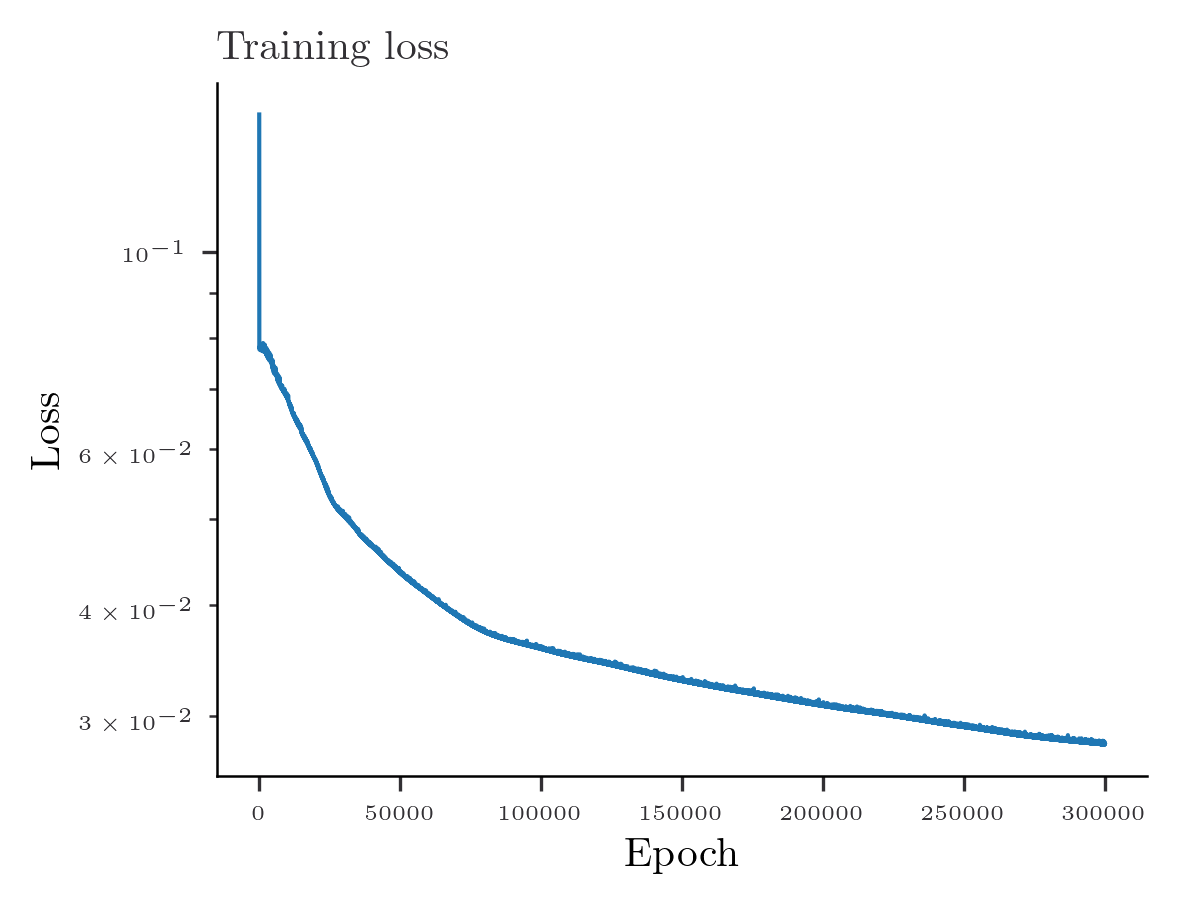

In [139]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

In [140]:
n_eval = n_coef
x_eval = jnp.linspace(lower, upper, n_eval)
y_eval = jnp.linspace(lower, upper, n_eval)
X, Y = jnp.meshgrid(x_eval, y_eval)
interior_eval = create_interior(x_eval, y_eval)
u_eval =evaluate_basis_sine_2d(x_eval,y_eval, coef_u)

In [141]:
pred_grid = neural_network(params, interior_eval).reshape(n_eval, n_eval)

In [142]:
print(compute_2d_error(pred_grid, u_eval, x_eval, y_eval))

(Array(0.08326969, dtype=float64), Array(0.25635849, dtype=float64))


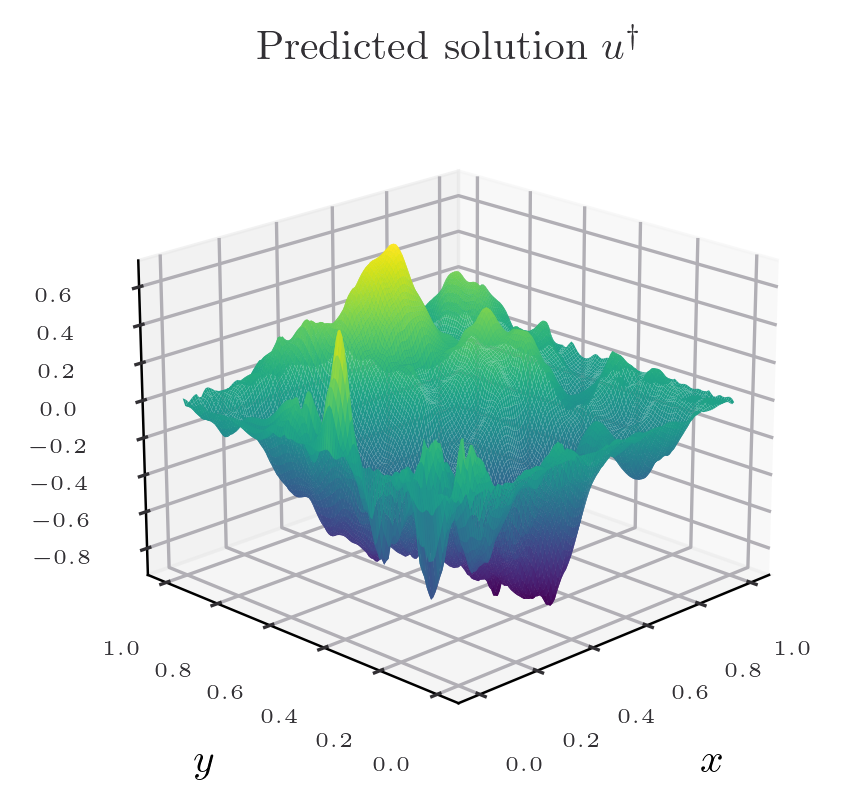

In [143]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

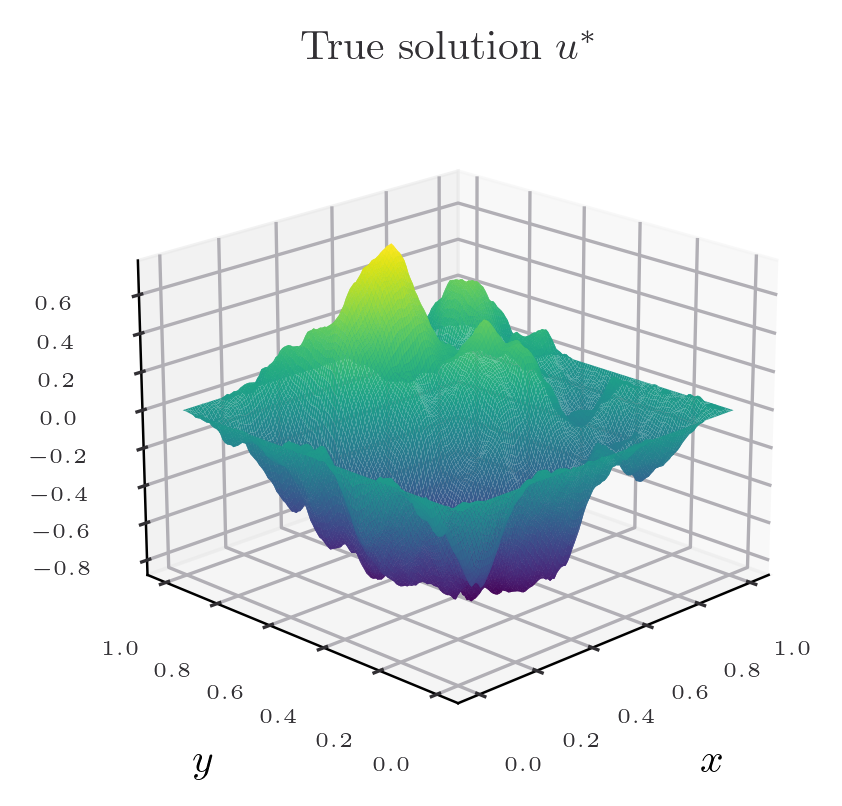

In [144]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_eval,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

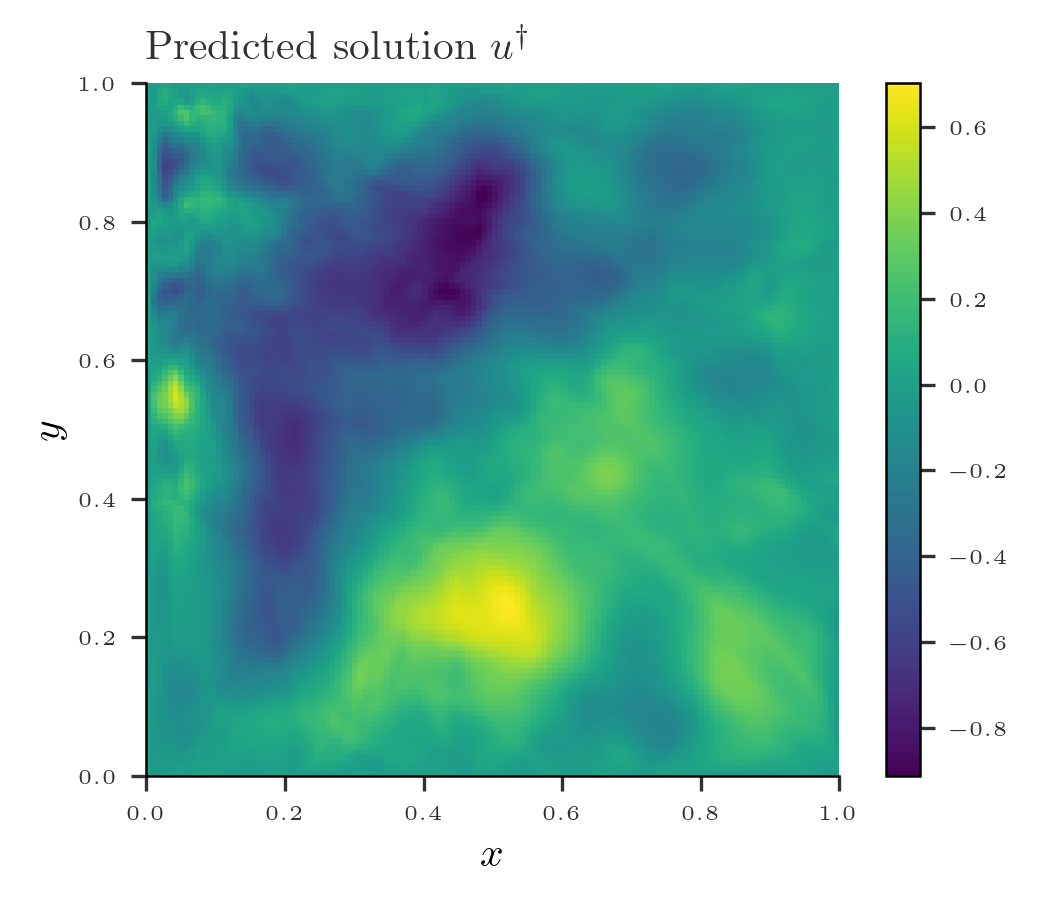

In [145]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_grid, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Predicted solution $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

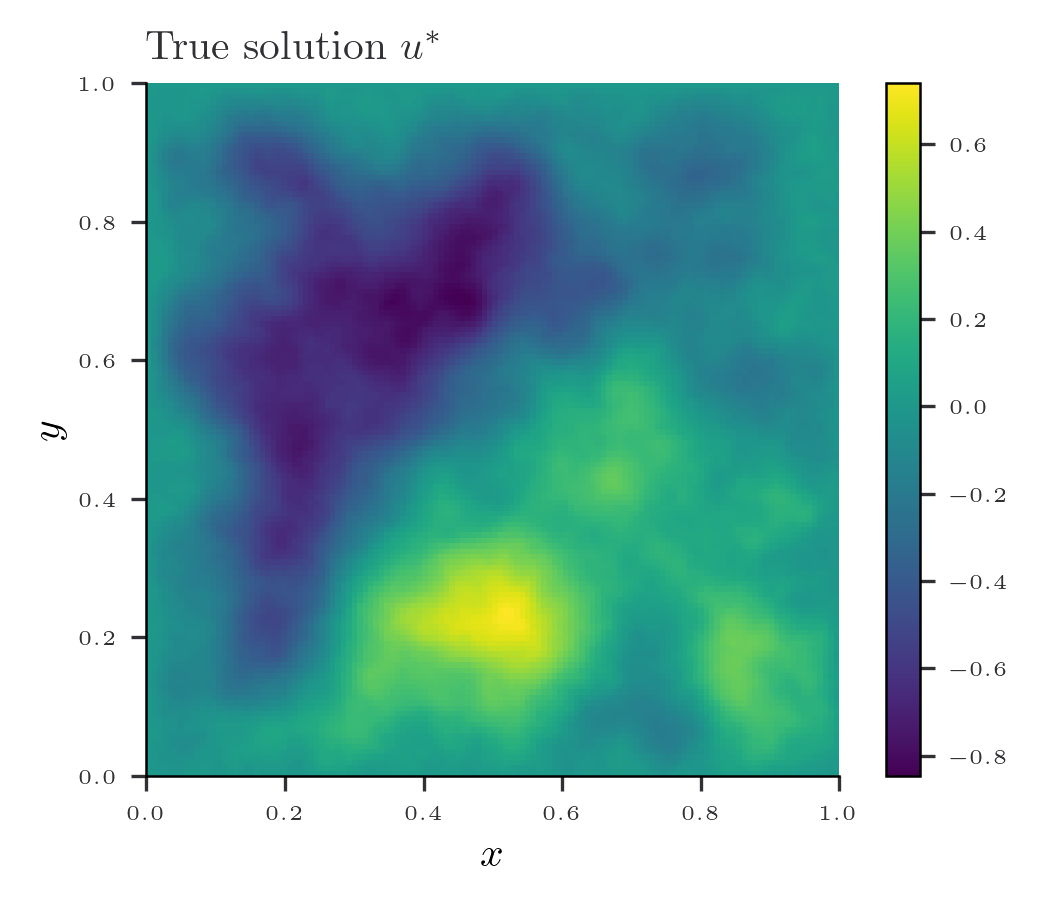

In [146]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

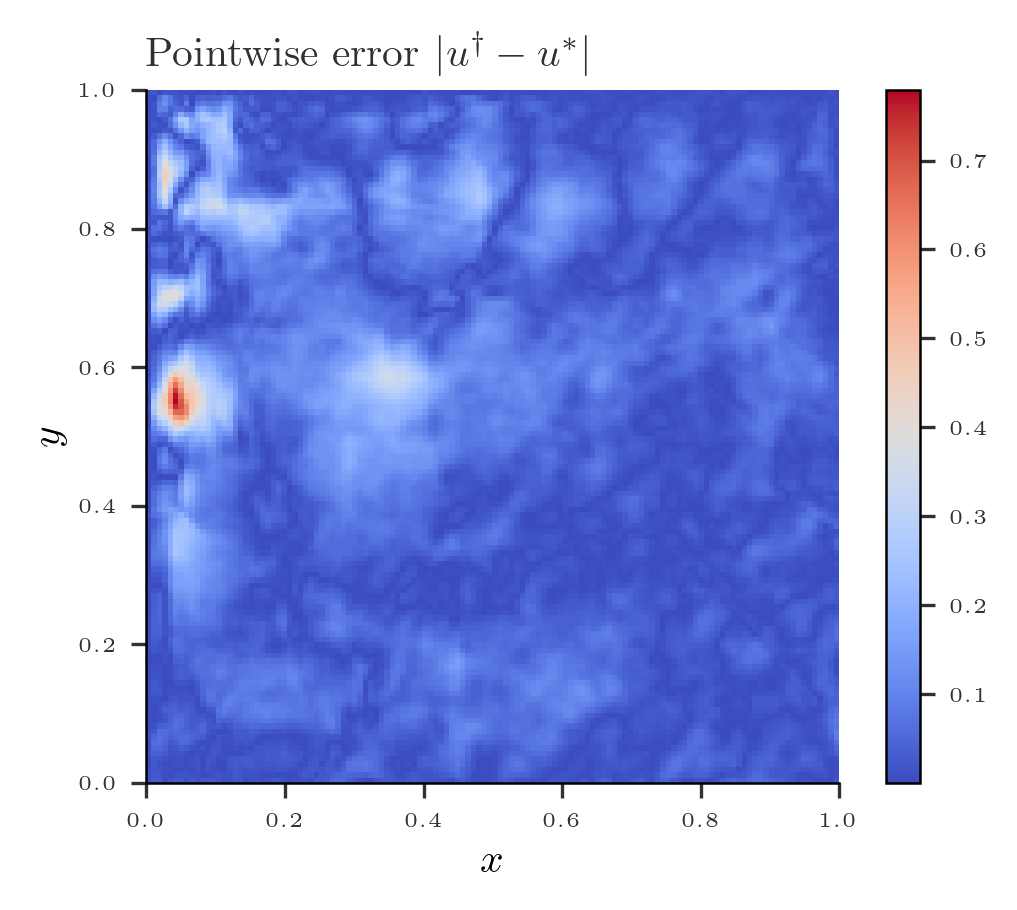

In [147]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_grid - u_values), cmap='coolwarm', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# $L^2$ norm + $\ell^2$ regularization

In [148]:
layer_sizes = [2, 64, 64,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))


# def nn_laplacian(params, x):
#     nabla = grad(predict, argnums = -1)
#     g_1, g_2 = nabla
# nn_laplacian = jit(grad(grad(predict), argnums=-1))

def laplacian(params, x):
    return jnp.trace(hessian(predict, argnums=-1)(params, x))

nn_laplacian = jit(vmap(laplacian, in_axes = (None, 0)))


# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, n_points, w = 1.0):
    u_grid = neural_network(params, grid).reshape(n_points, n_points)
    non_linearity = tau(u_grid)
    laplacian_grid = nn_laplacian(params, grid).reshape(n_points, n_points)
    # Compute the sine transform
    pred_sine = dst_2d(-nu*laplacian_grid + non_linearity)
    residual_interior = (pred_sine - f)

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 4417 parameters in the neural network.


In [149]:
f_observed =  f_trans[:n_points,:n_points]

In [150]:
loss_fn(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points, w = 1.0)

Array(0.1429061, dtype=float64)

In [151]:
loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points, w = 1.0)
print(loss, grads)

0.14290609586229758 [(Array([[ 2.06176035e-03,  4.50122239e-03, -8.97447205e-03,
        -1.11702131e-02, -1.00695391e-02, -8.14631997e-03,
         9.70463762e-03,  4.08054266e-03, -2.70373995e-03,
        -1.47408070e-04,  4.21321862e-03, -1.97135073e-03,
        -8.45282553e-03, -6.36238422e-05, -2.63095656e-03,
        -2.99917799e-03, -5.28776691e-03, -6.69463666e-03,
         1.78511739e-04, -7.66750394e-04,  5.72717245e-03,
         2.57528999e-03, -1.97325296e-03,  3.94299448e-03,
        -1.16427823e-03,  2.06500355e-03, -5.54347842e-03,
         8.04860724e-04,  1.46819748e-03, -7.44414312e-03,
        -6.13026072e-03, -2.75351455e-04,  4.15772140e-04,
        -5.32633153e-03,  1.98846139e-03, -3.81058158e-03,
        -3.88547180e-04,  1.68926396e-03, -5.54410362e-03,
         4.82210916e-03, -3.55729000e-04, -1.77460976e-03,
        -4.22344517e-03, -5.95790895e-03, -5.10381737e-03,
         6.72353609e-05,  5.55818803e-03, -5.73501715e-03,
         2.67953641e-04,  2.108227

In [153]:
# Define the optimizer
optimizer = optax.adamw(1e-3, weight_decay = 1e-3)
opt_state = optimizer.init(params)

In [154]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [155]:
patience = 10**10  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0

In [156]:
loss_hist = []
num_epochs = 3e5
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
        best_param = params.copy()
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 0.1429061
Epoch 10000, Loss: 0.0683079
Epoch 20000, Loss: 0.0582462
Epoch 30000, Loss: 0.0512489
Epoch 40000, Loss: 0.0453520
Epoch 50000, Loss: 0.0406545
Epoch 60000, Loss: 0.0382696
Epoch 70000, Loss: 0.0367991
Epoch 80000, Loss: 0.0356076
Epoch 90000, Loss: 0.0345953
Epoch 100000, Loss: 0.0334791
Epoch 110000, Loss: 0.0325641
Epoch 120000, Loss: 0.0316606
Epoch 130000, Loss: 0.0310209
Epoch 140000, Loss: 0.0305979
Epoch 150000, Loss: 0.0300857
Epoch 160000, Loss: 0.0296819
Epoch 170000, Loss: 0.0293104
Epoch 180000, Loss: 0.0292869
Epoch 190000, Loss: 0.0285863
Epoch 200000, Loss: 0.0282815
Epoch 210000, Loss: 0.0280007
Epoch 220000, Loss: 0.0277150
Epoch 230000, Loss: 0.0274388
Epoch 240000, Loss: 0.0271666
Epoch 250000, Loss: 0.0268993
Epoch 260000, Loss: 0.0270867
Epoch 270000, Loss: 0.0263456
Epoch 280000, Loss: 0.0260860
Epoch 290000, Loss: 0.0258862


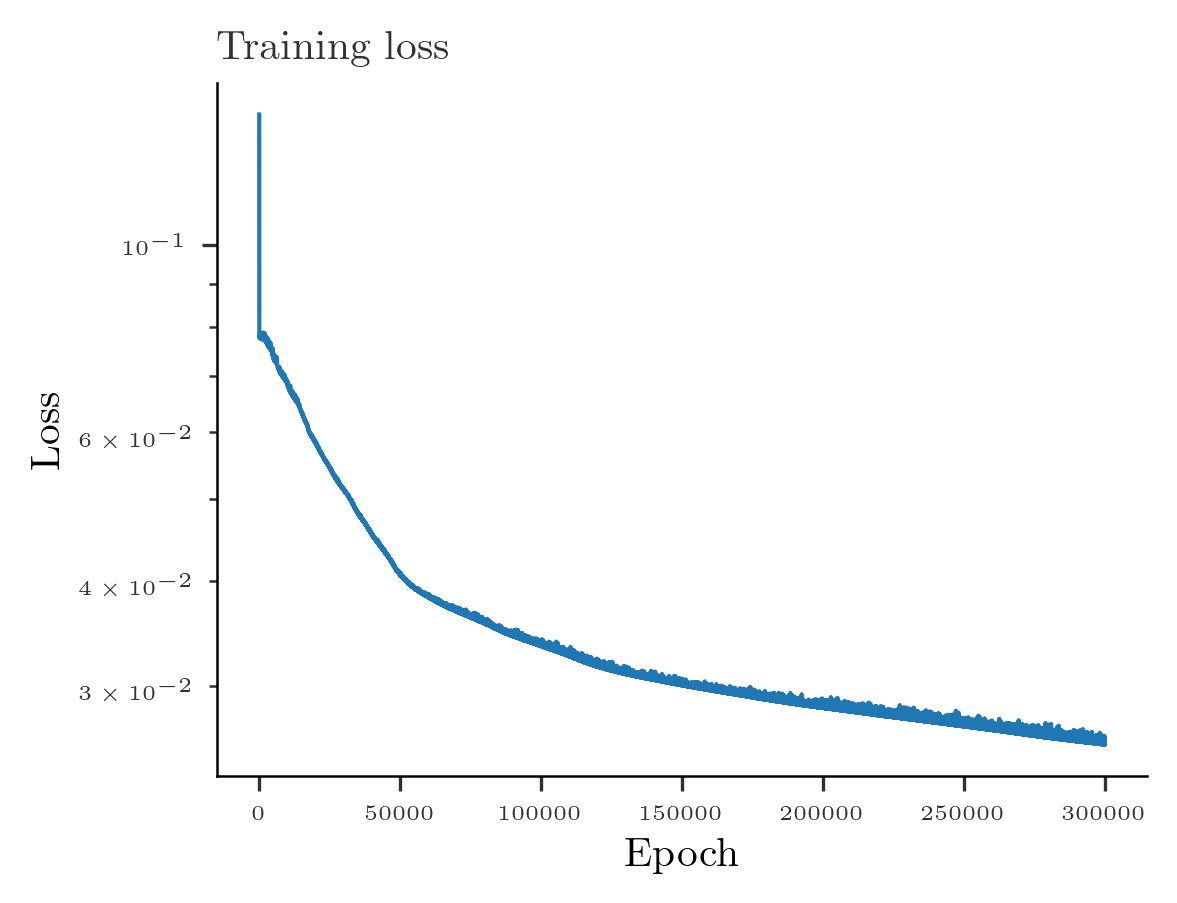

In [157]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

In [158]:
n_eval = n_coef
x_eval = jnp.linspace(lower, upper, n_eval)
y_eval = jnp.linspace(lower, upper, n_eval)
X, Y = jnp.meshgrid(x_eval, y_eval)
interior_eval = create_interior(x_eval, y_eval)
u_eval =evaluate_basis_sine_2d(x_eval,y_eval, coef_u)

In [159]:
pred_grid = neural_network(params, interior_eval).reshape(n_eval, n_eval)

In [160]:
print(compute_2d_error(pred_grid, u_eval, x_eval, y_eval))

(Array(0.14073513, dtype=float64), Array(0.43327464, dtype=float64))


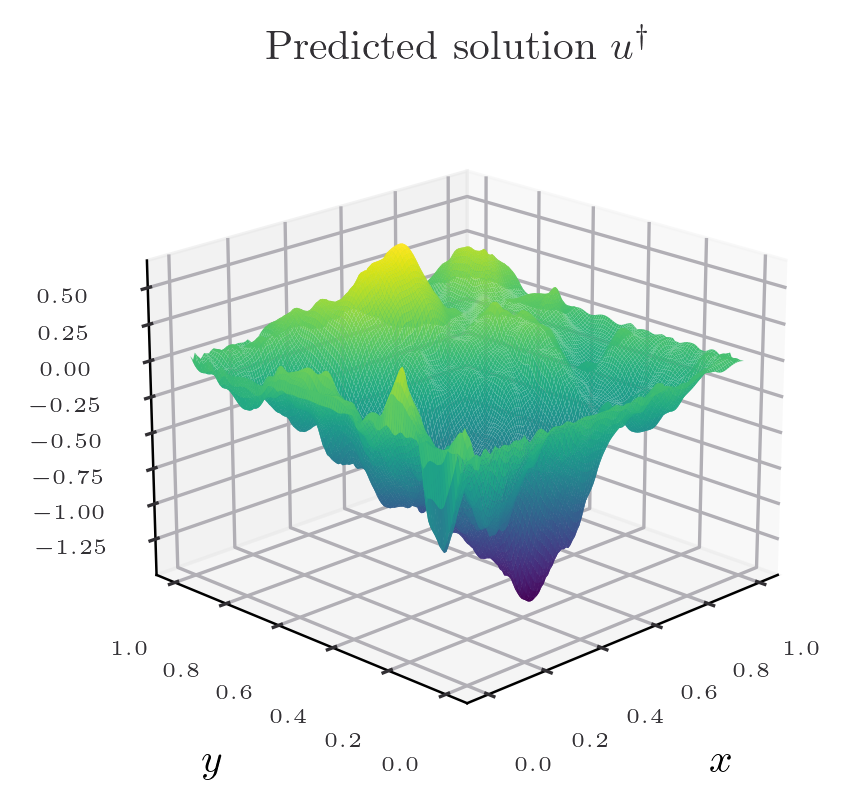

In [161]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

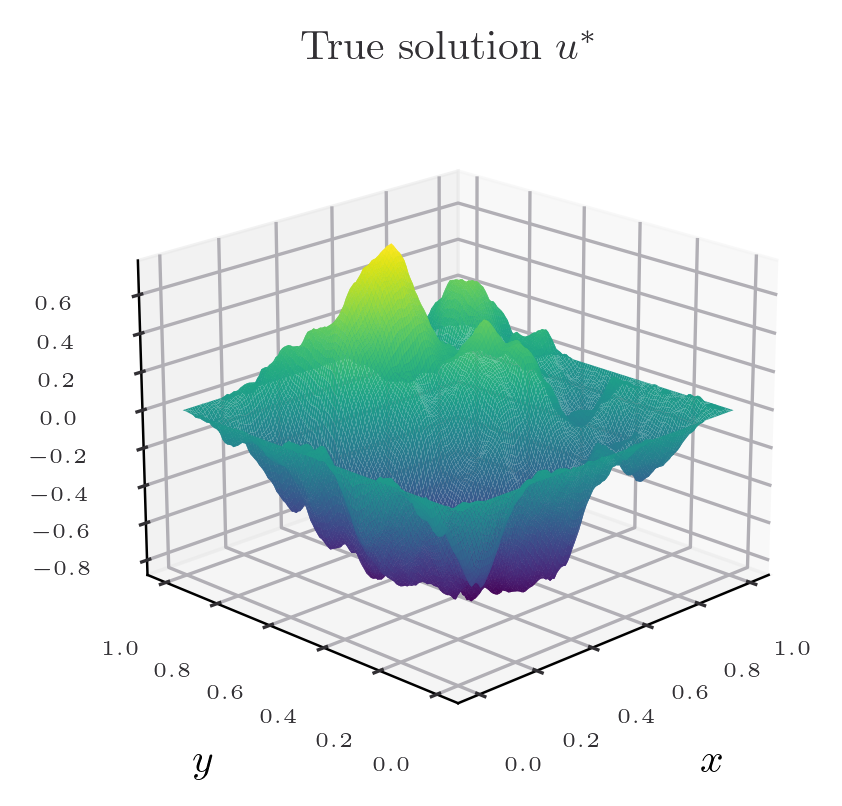

In [162]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_eval,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

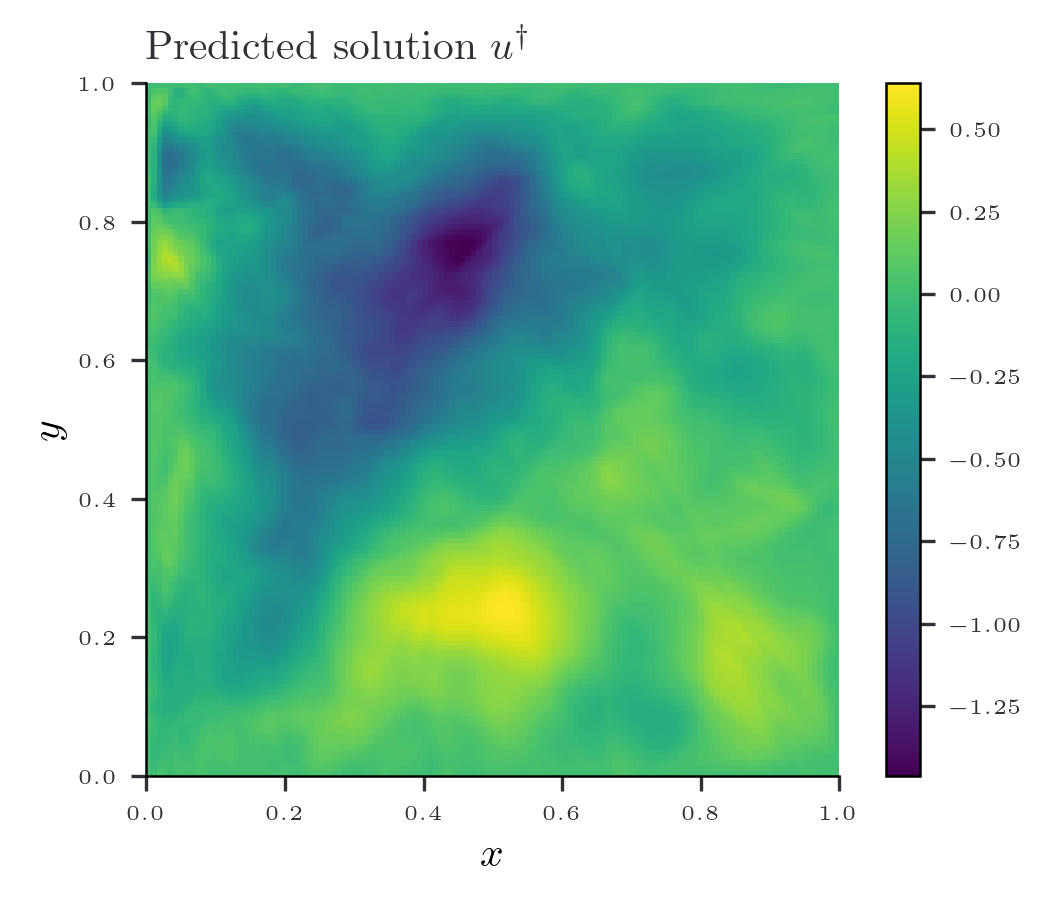

In [163]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_grid, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Predicted solution $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

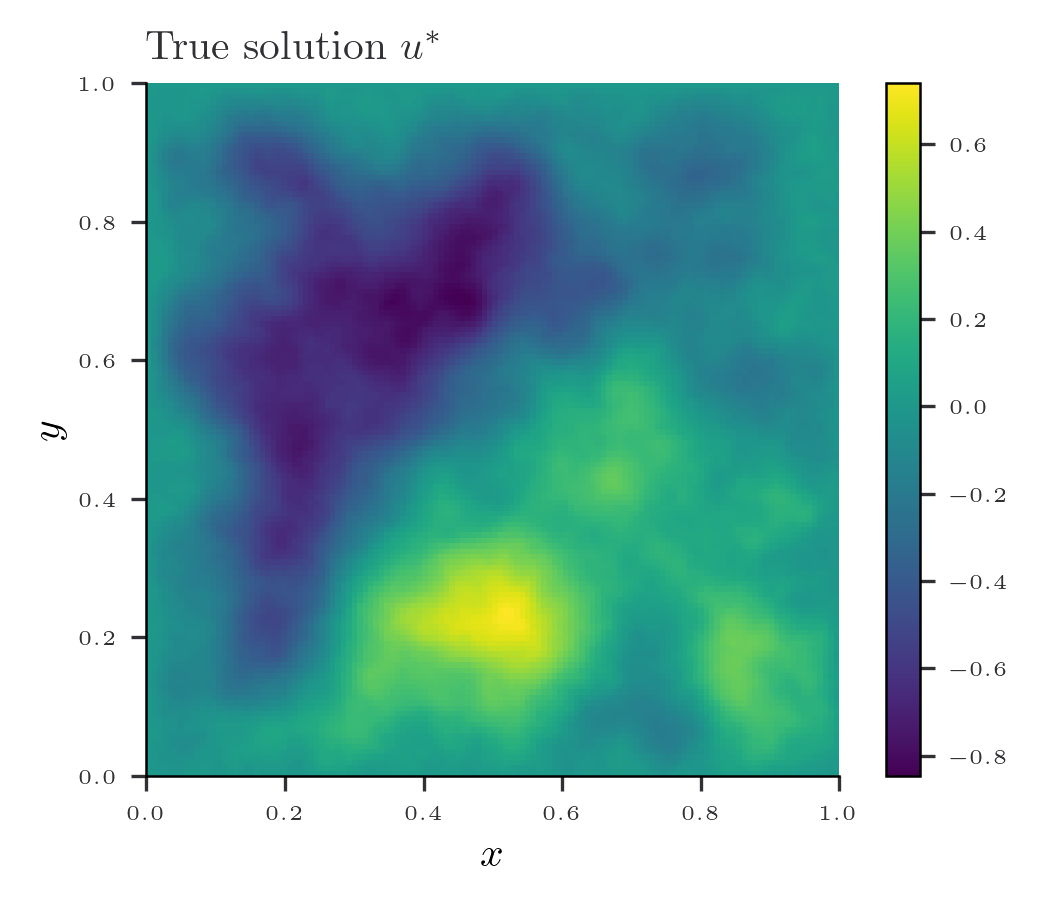

In [164]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

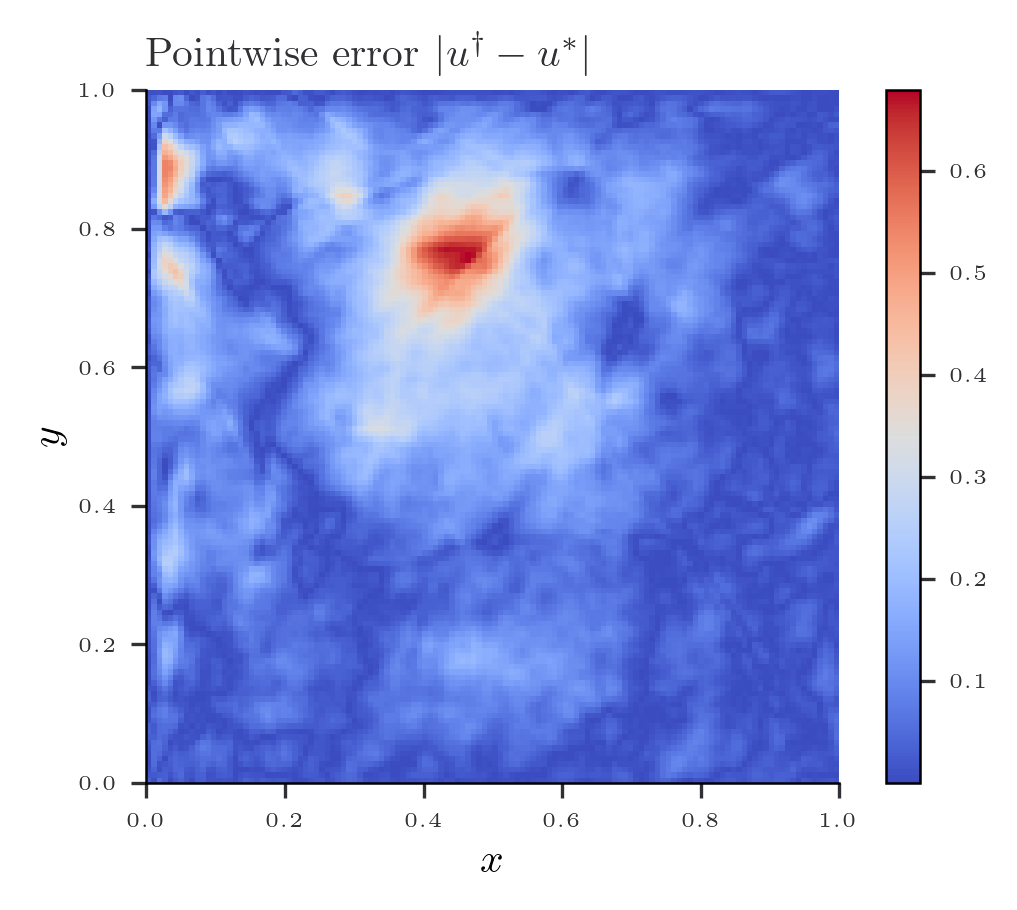

In [165]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_grid - u_values), cmap='coolwarm', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# Pointwise version

In [60]:
layer_sizes = [2, 64, 64,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))


# def nn_laplacian(params, x):
#     nabla = grad(predict, argnums = -1)
#     g_1, g_2 = nabla
# nn_laplacian = jit(grad(grad(predict), argnums=-1))

def laplacian(params, x):
    return jnp.trace(hessian(predict, argnums=-1)(params, x))

nn_laplacian = jit(vmap(laplacian, in_axes = (None, 0)))


# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, n_points, w = 1.0):
    u_grid = neural_network(params, grid).reshape(n_points, n_points)
    non_linearity = tau(u_grid)
    laplacian_grid = nn_laplacian(params, grid).reshape(n_points, n_points)
    # Compute the sine transform
    pred = -nu*laplacian_grid + non_linearity
    residual_interior = (pred - f)

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 4417 parameters in the neural network.


In [61]:
neural_network(params, interior).shape, nn_laplacian(params, interior).shape

((4096,), (4096,))

In [62]:
u_observed = evaluate_basis_sine_2d(x,y, coef_u)
f_observed =  evaluate_basis_sine_2d(x,y, coef_laplacian) + vmap_b(x, y)*u_observed + tau(u_observed)

In [63]:
loss_fn(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points, w = 1.0)

Array(1125.16985964, dtype=float64)

In [64]:
loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points, w = 1.0)
print(loss, grads)

1125.1698596357473 [(Array([[ 0.07094333,  0.03219249, -0.35441218, -0.35531132, -0.40059171,
        -0.27750859,  0.38194686, -0.04470554, -0.00795543,  0.20156826,
        -0.02661272,  0.00681565, -0.32709469,  0.02440358, -0.05136172,
        -0.19384506, -0.30115527, -0.26441028,  0.28614794, -0.04451056,
         0.3417139 ,  0.12551697, -0.01089502,  0.16479685,  0.06551364,
        -0.06321349, -0.15410507, -0.06336837,  0.09967264, -0.24564198,
        -0.1622596 , -0.00425662, -0.0951756 , -0.22898437,  0.05727186,
        -0.32104645,  0.0612727 ,  0.3536987 ,  0.11903608,  0.0311402 ,
         0.03246761, -0.03615558, -0.35264243, -0.17463078, -0.1348852 ,
         0.12225059,  0.18371839, -0.20851342, -0.11474354,  0.02814436,
         0.05565563, -0.06362925, -0.05120348,  0.08346317,  0.11556856,
         0.00646646, -0.2445562 , -0.12768881, -0.06294548,  0.00228109,
        -0.05808982,  0.17523797,  0.29241886, -0.02848449],
       [ 0.11566715,  0.08386102, -0.62707

In [65]:
# Define the optimizer
optimizer = optax.adamw(1e-3, weight_decay = 0.0)
opt_state = optimizer.init(params)

In [66]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [67]:
patience = 10**10  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0

In [68]:
loss_hist = []
num_epochs = 3e5
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
        best_param = params.copy()
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 1125.1698596
Epoch 10000, Loss: 808.4820623
Epoch 20000, Loss: 775.1705007
Epoch 30000, Loss: 759.0805830
Epoch 40000, Loss: 747.5272669
Epoch 50000, Loss: 737.7741230
Epoch 60000, Loss: 730.7942841
Epoch 70000, Loss: 724.9367346
Epoch 80000, Loss: 719.9701991
Epoch 90000, Loss: 715.8799511
Epoch 100000, Loss: 712.4751972
Epoch 110000, Loss: 709.2649084
Epoch 120000, Loss: 706.2765550
Epoch 130000, Loss: 703.4966238
Epoch 140000, Loss: 700.9852838
Epoch 150000, Loss: 699.1846086
Epoch 160000, Loss: 695.4167715
Epoch 170000, Loss: 691.9546997
Epoch 180000, Loss: 689.8263721
Epoch 190000, Loss: 683.4919422
Epoch 200000, Loss: 681.3646717
Epoch 210000, Loss: 678.1888334
Epoch 220000, Loss: 678.2323832
Epoch 230000, Loss: 672.5792040
Epoch 240000, Loss: 670.6109177
Epoch 250000, Loss: 667.7251476
Epoch 260000, Loss: 665.8024500
Epoch 270000, Loss: 660.5404885
Epoch 280000, Loss: 660.3740030
Epoch 290000, Loss: 660.0442391


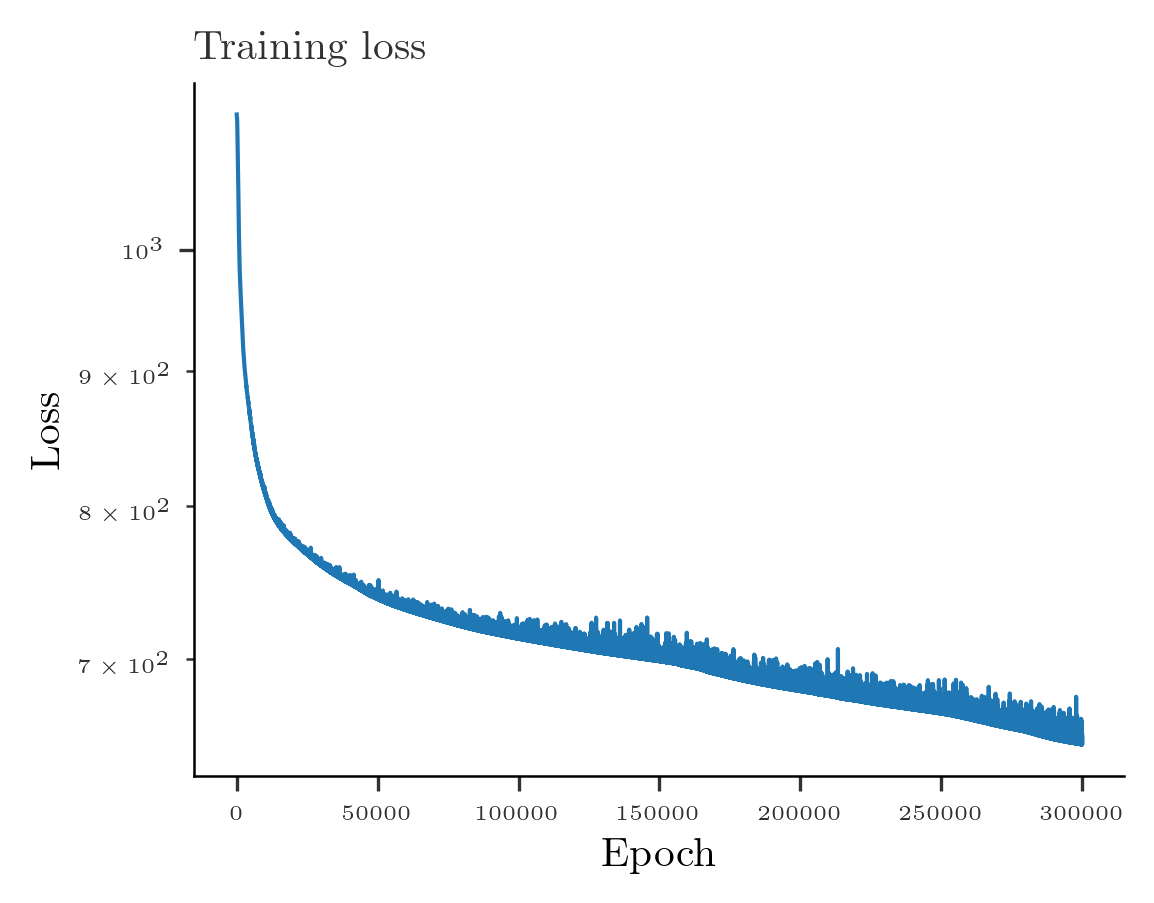

In [69]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

In [70]:
n_eval = n_coef
x_eval = jnp.linspace(lower, upper, n_eval)
y_eval = jnp.linspace(lower, upper, n_eval)
X, Y = jnp.meshgrid(x_eval, y_eval)
interior_eval = create_interior(x_eval, y_eval)
u_eval =evaluate_basis_sine_2d(x_eval,y_eval, coef_u)

In [71]:
pred_grid = neural_network(params, interior_eval).reshape(n_eval, n_eval)

In [72]:
print(compute_2d_error(pred_grid, u_eval, x_eval, y_eval))

(Array(0.2615841, dtype=float64), Array(0.80532669, dtype=float64))


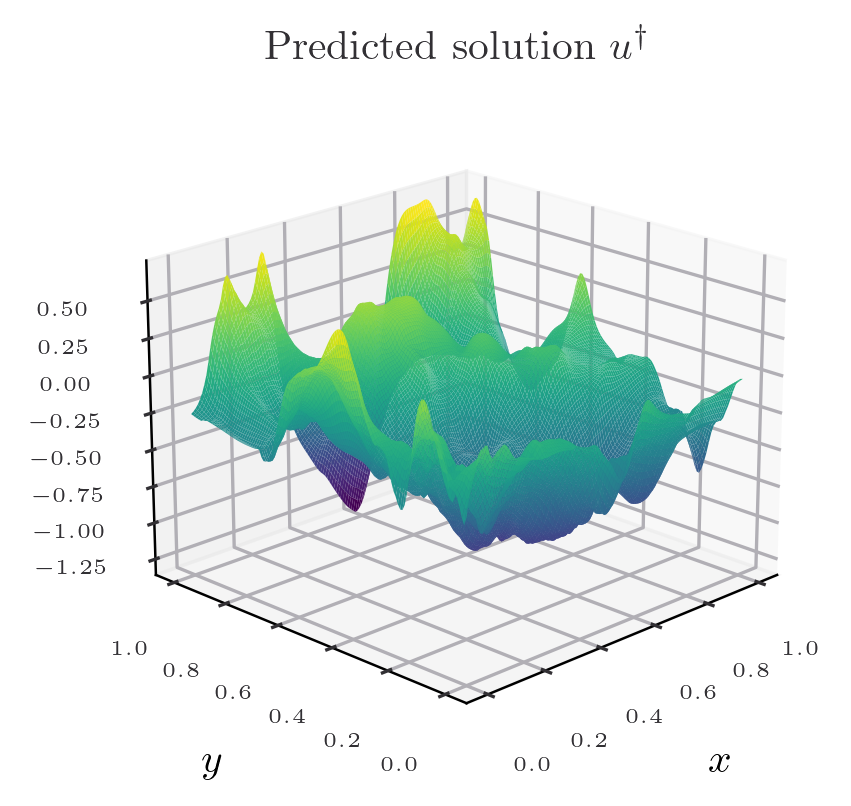

In [73]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

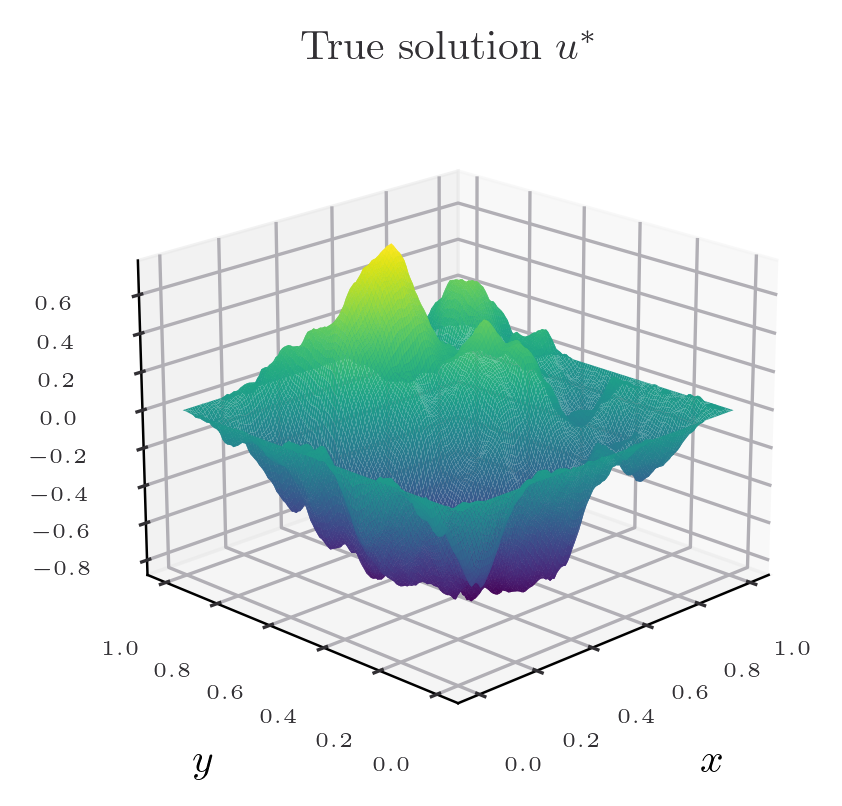

In [74]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_eval,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

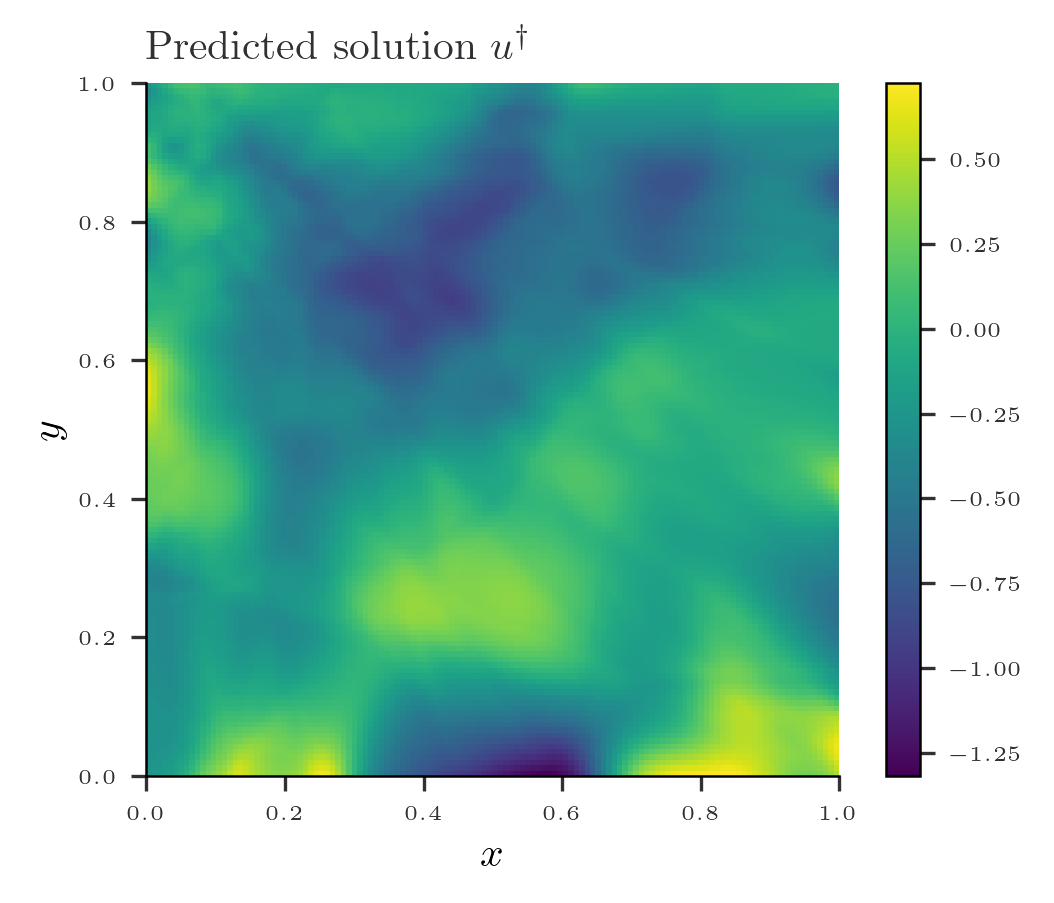

In [75]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_grid, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Predicted solution $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

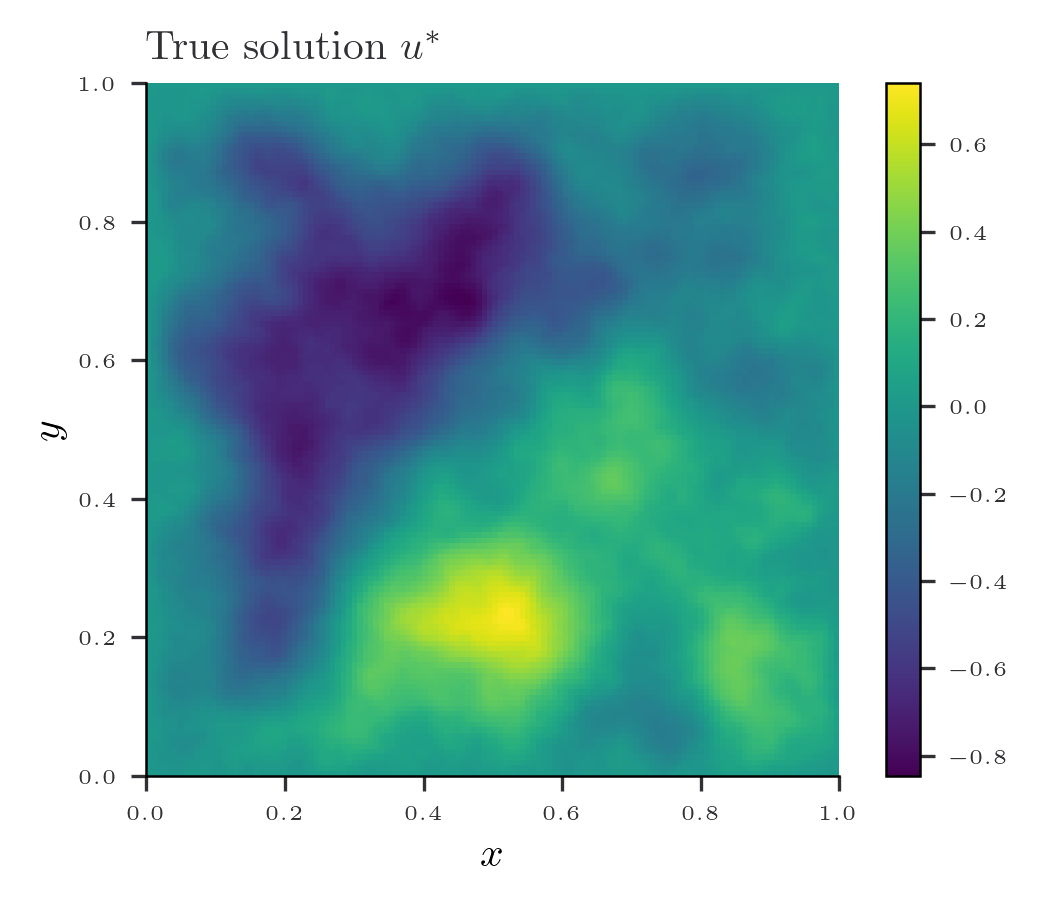

In [76]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

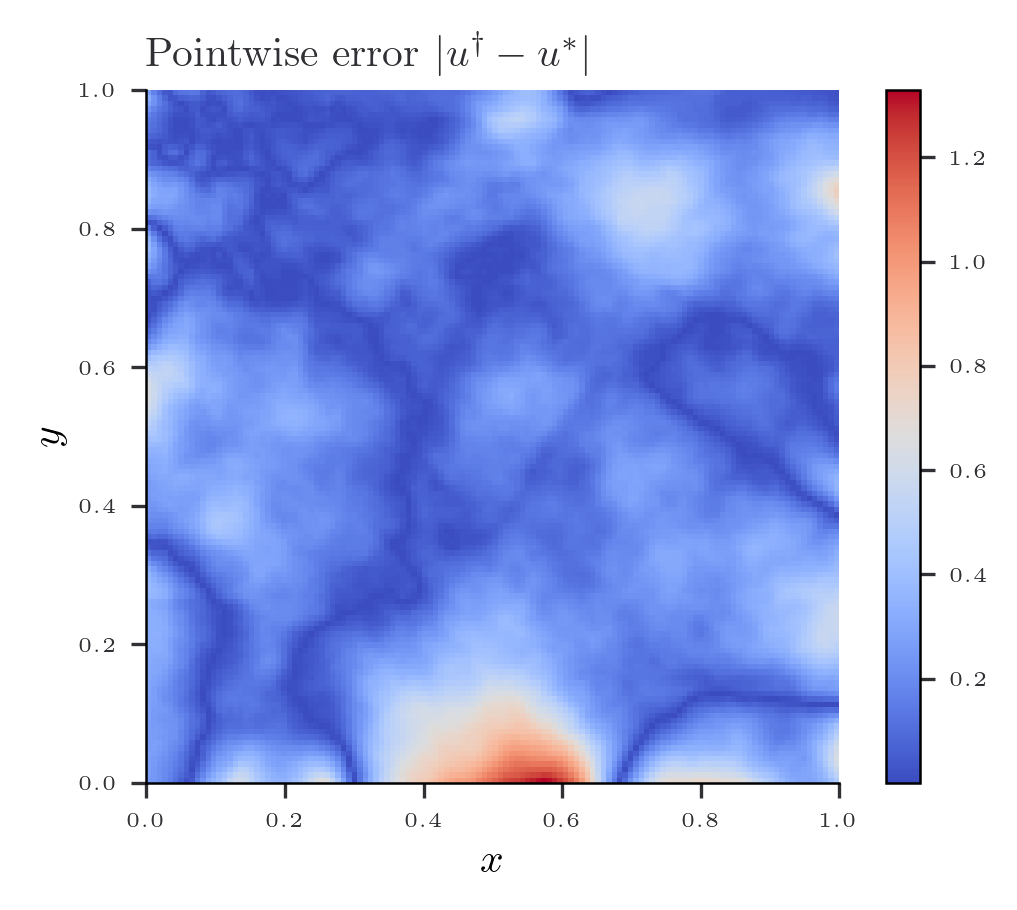

In [77]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_grid - u_values), cmap='coolwarm', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()